<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/230521_DD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data drift에 내성이 있는 학습 방법

In [3]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [5]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)

# 실험을 위한 기본적인 function 들...

In [6]:

!git clone https://github.com/yuji-roh/fr-train.git

Cloning into 'fr-train'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 31 (delta 9), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), 168.32 KiB | 2.59 MiB/s, done.


In [7]:

%cd fr-train
!pwd

/content/fr-train
/content/fr-train


In [8]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

In [9]:

def test_model(model_,model2_, tX, ty, s1):
    model_.eval()
    model2_.eval()

    ax = model2_(tX[:,0:5],tX[:,5].reshape(-1,1)/avaible_range)

    y_hat = model_(ax)
    y_hat = (y_hat.data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)
    
    f1 = f1_score(ty,y_hat)
    #print('R-squared score',r2)
    mi_scores = make_mi_scores(pd.DataFrame(tX[:,4],columns=['z0']), y_hat, discrete_features="auto")
    mi = mi_scores['z0']
    print("Test f1 score: {}".format(f1))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))
#     min_eo = min(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     max_eo = max(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     print("Equal Opportunity ratio = {:.3f}".format(min_eo/max_eo))
    return f1, mi

In [10]:
# Define the Generator
class Generator(nn.Module):
    """FR-Train generator (classifier).
    
    This class is for defining the structure of FR-Train generator (classifier). 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self):
        """Initializes Generator with torch components."""
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 20),
            nn.ReLU(),
            nn.Linear(20, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
            
        Returns:
            The predicted label (y_hat) for the given input data.
        """
        
        output = self.model(input_data)
        return output


In [11]:

def test_all_data(generator,adapter,XT,yT):

    #XT = X[train_size:][['x0','x1','x2','x3','z0','b']]
    #yT = y[train_size:]
    print('XT.shape',XT.shape)
    bucket_size_array=[200]
    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)-1
        f1s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)
            xs = adapter(tmp_x[:,0:5],tmp_x[:,5].reshape(-1,1)/avaible_range)
            predicted_y = generator(xs)
            predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
            f1 = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)
        plt.figure(figsize=(15,3))
        plt.plot(f1s)
        plt.show()

    print('Mean F1 for all data:',np.mean(f1s))   
    return f1s

In [12]:
#  I(Z,B) > 0의 관계에 대해 z0를 전처리
class Sensitivity_Adapter(nn.Module):
   
    def __init__(self,input_dim):
        """Initializes DiscriminatorF with torch components."""
        
        super(Sensitivity_Adapter, self).__init__()

        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        #self.fc3 = nn.ModuleList()
        
        for i in range(self.input_dim): 
            self.fc1.append(nn.Linear(2, 30))
            self.fc2.append(nn.Linear(30, 1))
            #self.fc3.append(nn.Linear(5, 1))

    def forward(self,x,b):
        pxy = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1)))
            #h1 = F.relu(self.fc2[i](h0))
            #h0 = self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1))
            #h1 = self.fc2[i](h0)
            h2 = self.fc2[i](h0)
            pxy.append(h2)
            
        return torch.cat(pxy, dim=1)
     

In [13]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):

    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    #mine = Net()
    #optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)

    minibatch = 1000

    for epoch in range(n_epochs):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------
        xs = adapter(XS_train[:,0:5],XS_train[:,5].reshape(-1,1)/avaible_range) # z0, b
        a_loss = torch.sum(mse_loss(xs, XS_train[:,0:5]))

        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        optimizer_A.zero_grad()
        #optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        #loss.backward()
        mi_losses.append(a_loss)
        #optimizer_D_F.step()

        loss = (1-lambda_f) * g_loss +  lambda_f * a_loss * alpha #* 0.05

        loss.backward()
        optimizer_G.step()
        #optimizer_M.step()
        optimizer_A.step()            

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    r2,mi = test_model(generator,adapter, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return r2,mi,generator,adapter

# 준비
+ synthetic data를 만든다.
+ 해당 data는 data drift가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다.

## synthetic data의 생성 (Case #1 MI의 감소, Drift의 증가 )



+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift

In [14]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [15]:
seed_everything()

y= (np.random.normal(0.5,0.5,100) > 0.5).astype(int)
sum(y)

40

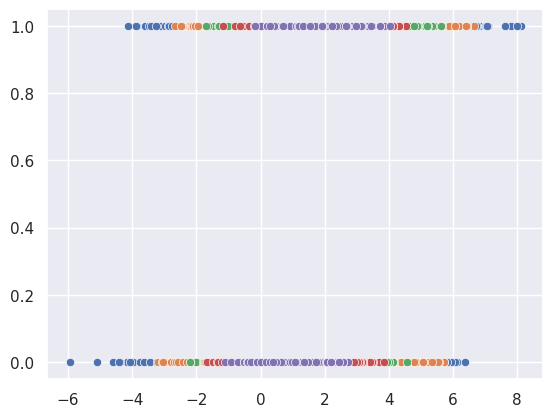

In [16]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    sns.scatterplot(x=x[:,ix],y=y)

<Axes: >

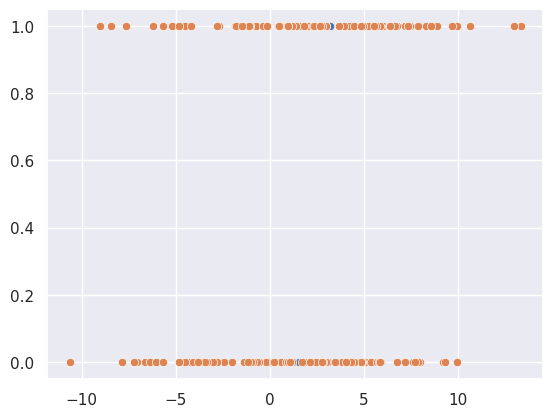

In [17]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)    
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
sns.scatterplot(x=x[0:200,4],y=y[0:200])
sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

## KS-test 통계량의 측정

In [18]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]   
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)
    
    #if ks_stat == minS:
    #    ks_stat = -ks_stat
    
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [19]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [20]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x3    0.202783
x2    0.134082
x1    0.079411
x0    0.050887
z0    0.027068
Name: MI Scores, dtype: float64


Bucket size 10


100%|██████████| 10/10 [00:01<00:00,  9.74it/s]


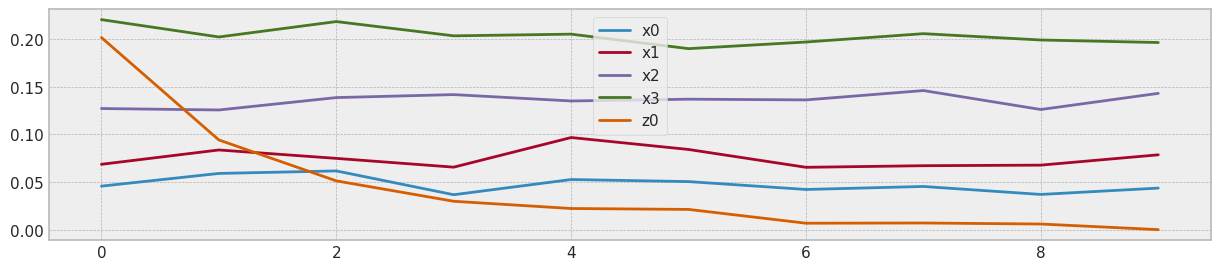

Bucket size 50


100%|██████████| 50/50 [00:01<00:00, 40.97it/s]


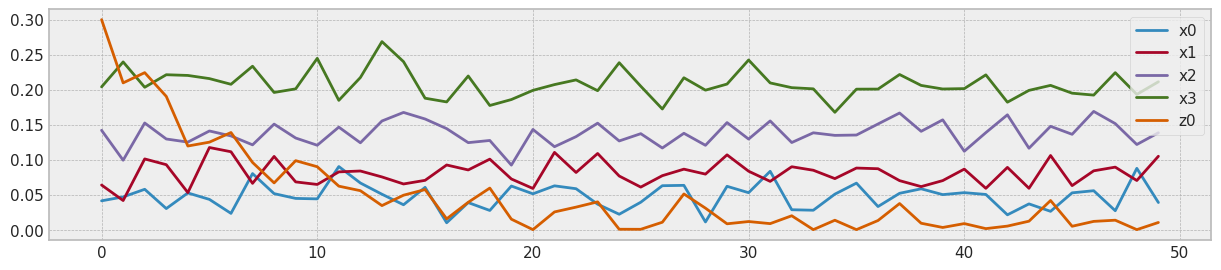

Bucket size 100


100%|██████████| 100/100 [00:01<00:00, 65.36it/s]


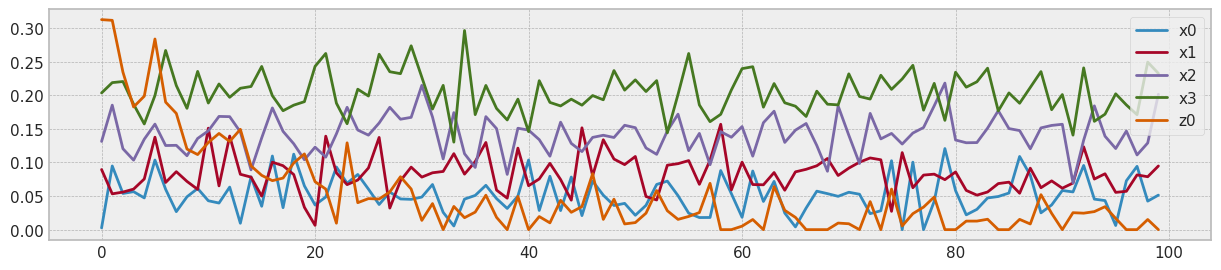

Bucket size 200


100%|██████████| 200/200 [00:02<00:00, 89.48it/s]


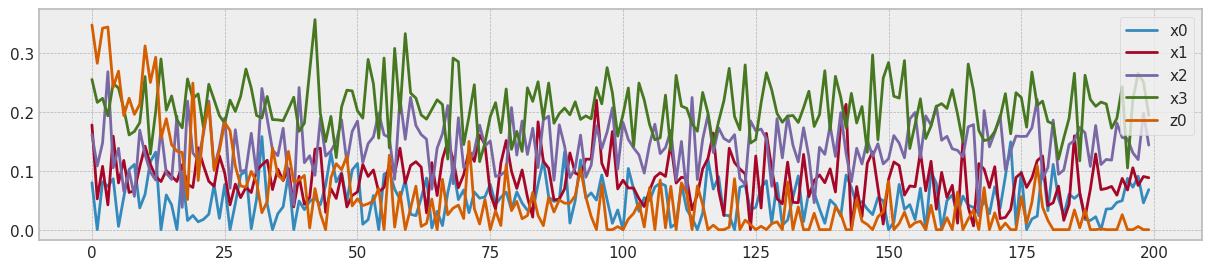

In [21]:
from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int(x.shape[0]/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X[bk*step_size:bk*step_size+step_size], y[bk*step_size:bk*step_size+step_size], discrete_features="auto")
        for col in columns:
            MIS[col].append(mi_scores[col]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

Bucket size 10


100%|██████████| 10/10 [00:00<00:00, 243.43it/s]


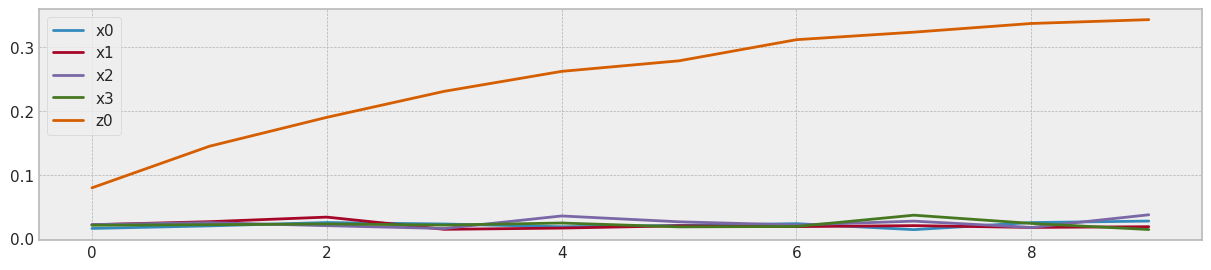

Bucket size 50


100%|██████████| 50/50 [00:00<00:00, 546.89it/s]


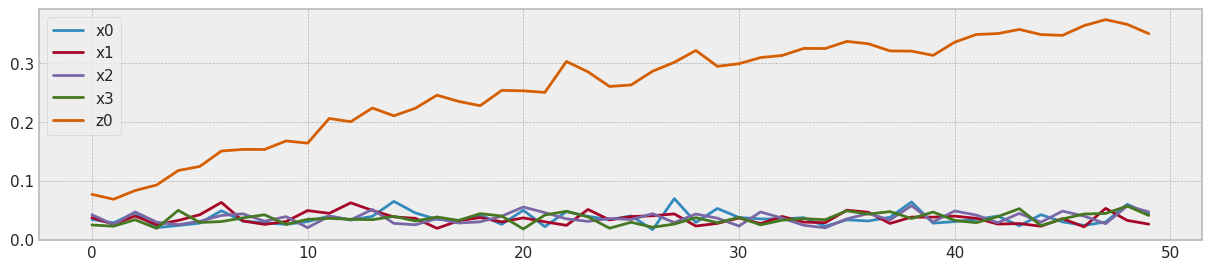

Bucket size 100


100%|██████████| 100/100 [00:00<00:00, 687.69it/s]


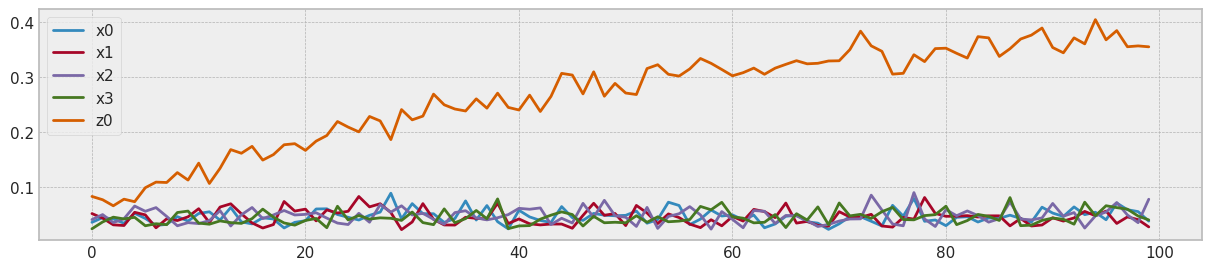

Bucket size 200


100%|██████████| 200/200 [00:00<00:00, 768.46it/s]


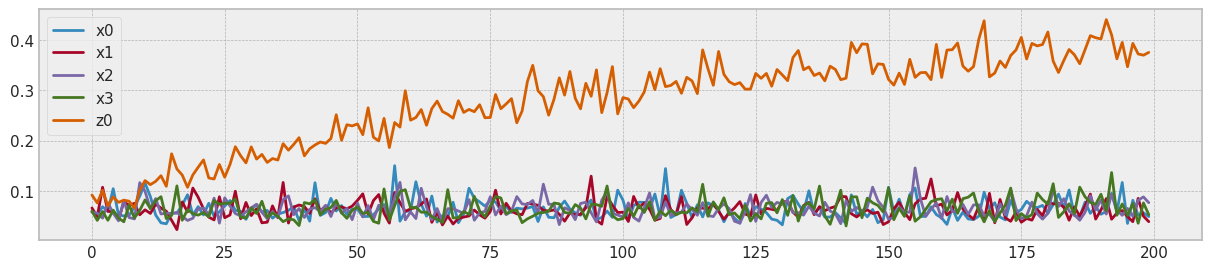

In [22]:
from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int((x.shape[0]-2000)/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)

        ks = __ks_drift(X[0:1800].values,X[bk*step_size+2000:bk*step_size+step_size+2000].values)
        #print(ks[:,0])
        for ix,col in enumerate(columns):
            MIS[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

## 학습 및 전체 예측

+ 2000개를 학습하고, 이후 38000개를 추정한다.

100%|██████████| 1000/1000 [00:20<00:00, 48.38it/s]


MSE: 0.26
RMSE: 0.51


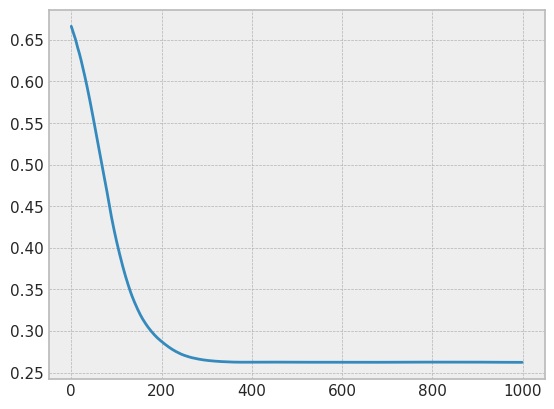

In [23]:
import copy
import torch.optim as optim
 
seed_everything()

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [24]:
result_table3 = {}
result_table3['lambda']=[]
result_table3['test_f1']=[]
result_table3['init_f1']=[]
result_table3['mean_f1']=[]
result_table3['last_f1']=[]
result_table3['MI(y^,z)']=[]

In [25]:

from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test,(predicted_y.data.numpy()> 0.5).astype(float))
print('feature 5, test_f1',f1)

feature 5, test_f1 0.8685714285714285


100%|██████████| 189/189 [00:00<00:00, 508.07it/s]


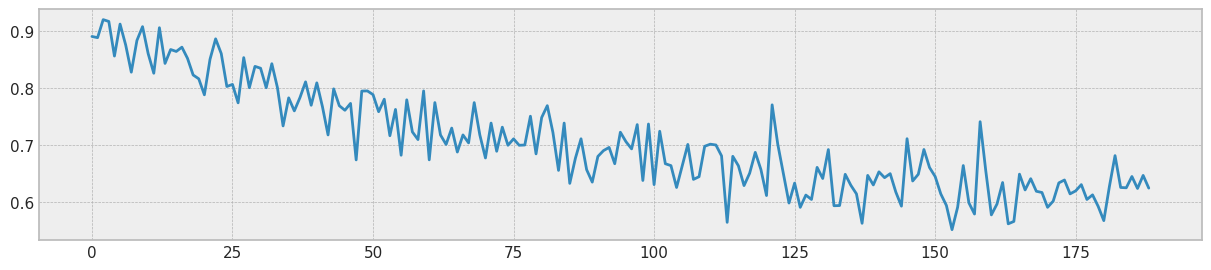

{'lambda': ['Case #1 Feature 5'], 'test_f1': [0.8685714285714285], 'init_f1': [0.8899082568807338], 'mean_f1': [0.7058765598487894], 'last_f1': [0.6238532110091742], 'MI(y^,z)': [0.0]}


In [26]:

XT = X[2000:][['x0','x1','x2','x3','z0']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.show()

result_table3['lambda'].append('Case #1 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

print(result_table3)

In [27]:
pd.DataFrame(result_table3)

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853       0.0

## 내성 학습의 적용

In [28]:

# bucket 하나의 크기는 100
# 2000개의 학습데이터에는 20개의 bucket이 있음.
# 학습데이터 100개당 +1의 bucket count를 증가 시킴
X['b'] = [int(b) for b in X.index.values/100]
X

x0        x1        x2        x3        z0    b
0      2.231833  0.663053  2.160447  1.180836  1.125117    0
1      1.326272  2.285045  2.362769  2.638806  2.171340    0
2      1.845348  3.743190  3.310210  1.772473  2.576518    0
3      2.974414 -0.229197  1.024580  1.387895  0.873782    0
4      2.854022  3.102544  1.610779  1.774781  2.490660    0
...         ...       ...       ...       ...       ...  ...
39995  0.085122 -0.571732  1.527233  1.867146 -1.177338  399
39996  1.069521 -0.221247  1.324087  1.798258  4.045168  399
39997  0.429295  2.593988  2.329410  1.859496  1.785665  399
39998  1.611266 -0.588687 -0.591898  2.126287  9.291351  399
39999  3.872531  0.931353  3.595759  1.948642  7.307901  399

[40000 rows x 6 columns]

[Lambda: 0.000000] [Epoch 0/4000] [mi loss: 3.831744] [G loss: 0.692209]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss: 23.307772] [G loss: 0.613722]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss: 125.971642] [G loss: 0.339407]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss: 291.945648] [G loss: 0.235181]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss: 355.605713] [G loss: 0.227341]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss: 378.131287] [G loss: 0.225182]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss: 389.046906] [G loss: 0.223749]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss: 404.750854] [G loss: 0.222455]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss: 426.580048] [G loss: 0.221166]
[Lambda: 0.000000] [Epoch 1800/4000] [mi loss: 451.049652] [G loss: 0.219849]
[Lambda: 0.000000] [Epoch 2000/4000] [mi loss: 478.030121] [G loss: 0.218689]
[Lambda: 0.000000] [Epoch 2200/4000] [mi loss: 511.811768] [G loss: 0.217526]
[Lambda: 0.000000] [Epoch 2400/4000] [mi loss: 557.146240] [G loss: 0.2164

100%|██████████| 189/189 [00:00<00:00, 368.52it/s]


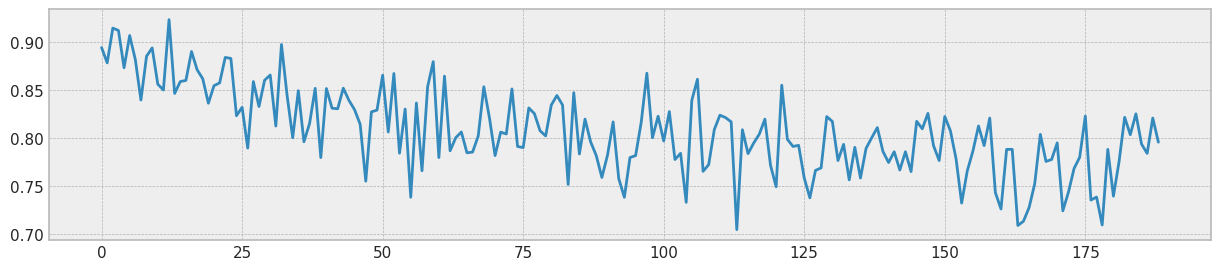

Mean F1 for all data: 0.807732092580134
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 3.831744] [G loss: 0.692209]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 0.046312] [G loss: 0.675293]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 0.045887] [G loss: 0.633281]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: 0.126462] [G loss: 0.575082]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: 0.225430] [G loss: 0.508245]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: 0.305090] [G loss: 0.445888]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 0.351183] [G loss: 0.391954]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: 0.362398] [G loss: 0.349315]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: 0.349711] [G loss: 0.319105]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: 0.323107] [G loss: 0.298509]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: 0.295724] [G loss: 0.283947]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: 0.268590] [G loss: 0.273525]
[Lambda: 0.100000] [Epoch 2400/4000] [mi loss: 0.245996

100%|██████████| 189/189 [00:00<00:00, 380.40it/s]


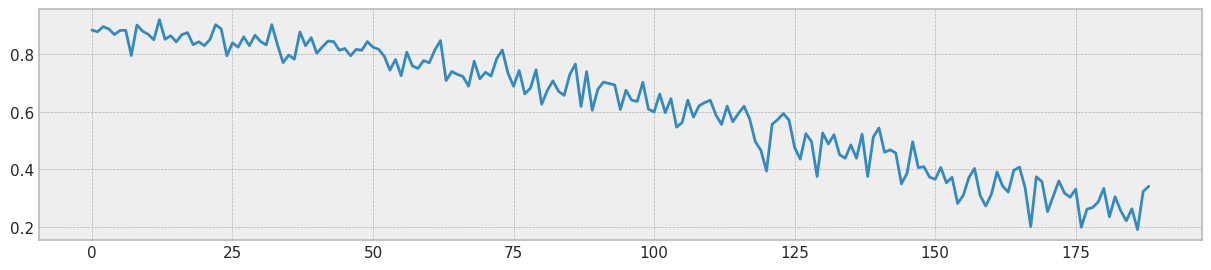

Mean F1 for all data: 0.6174002168025146
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 3.831744] [G loss: 0.692209]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 0.037821] [G loss: 0.676711]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 0.011691] [G loss: 0.640221]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 0.031525] [G loss: 0.593870]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: 0.060193] [G loss: 0.539695]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 0.087569] [G loss: 0.485400]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: 0.107742] [G loss: 0.433173]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: 0.120132] [G loss: 0.386354]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: 0.123073] [G loss: 0.349174]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: 0.119368] [G loss: 0.322621]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: 0.112321] [G loss: 0.303616]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: 0.102843] [G loss: 0.290081]
[Lambda: 0.200000] [Epoch 2400/4000] [mi loss: 0.09240

100%|██████████| 189/189 [00:00<00:00, 398.81it/s]


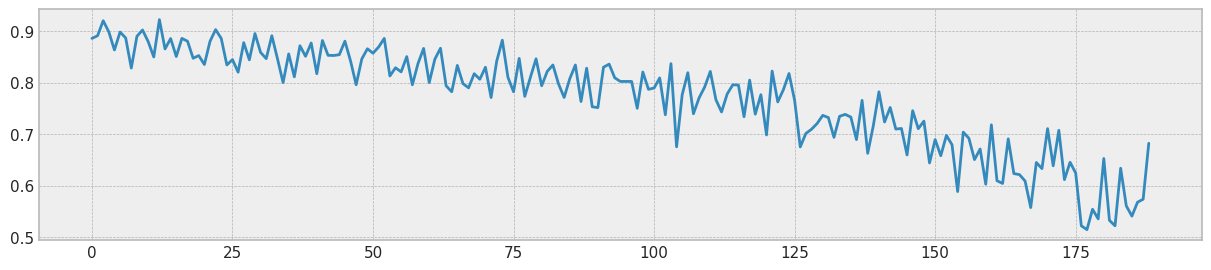

Mean F1 for all data: 0.7700048104055185
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 3.831744] [G loss: 0.692209]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 0.036050] [G loss: 0.677182]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 0.005574] [G loss: 0.642862]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 0.011685] [G loss: 0.601608]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: 0.023486] [G loss: 0.554085]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: 0.035564] [G loss: 0.505482]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: 0.046239] [G loss: 0.457113]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: 0.053670] [G loss: 0.411011]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: 0.057310] [G loss: 0.371821]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: 0.057011] [G loss: 0.341473]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: 0.052916] [G loss: 0.319163]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: 0.047584] [G loss: 0.301754]
[Lambda: 0.300000] [Epoch 2400/4000] [mi loss: 0.04207

100%|██████████| 189/189 [00:00<00:00, 378.12it/s]


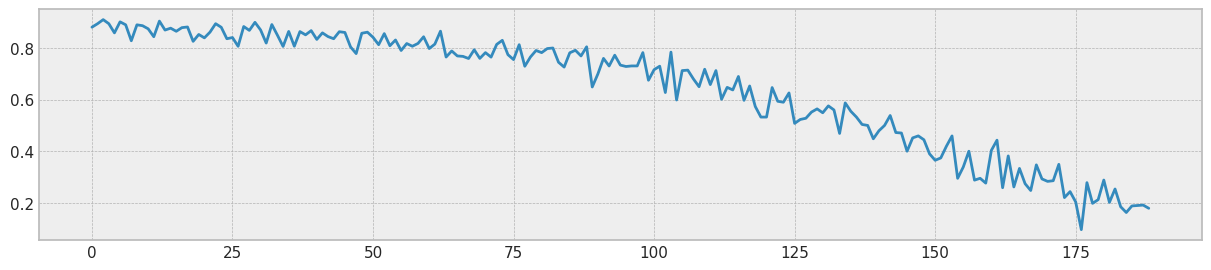

Mean F1 for all data: 0.6437032278939546
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 3.831744] [G loss: 0.692209]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 0.035375] [G loss: 0.677422]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 0.003500] [G loss: 0.644237]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 0.005452] [G loss: 0.605717]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 0.010486] [G loss: 0.562516]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 0.016123] [G loss: 0.517783]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 0.021489] [G loss: 0.472626]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 0.026359] [G loss: 0.427933]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 0.028712] [G loss: 0.388356]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 0.029764] [G loss: 0.355487]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 0.027915] [G loss: 0.330241]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 0.025202] [G loss: 0.310440]
[Lambda: 0.400000] [Epoch 2400/4000] [mi loss: 0.02227

100%|██████████| 189/189 [00:00<00:00, 388.31it/s]


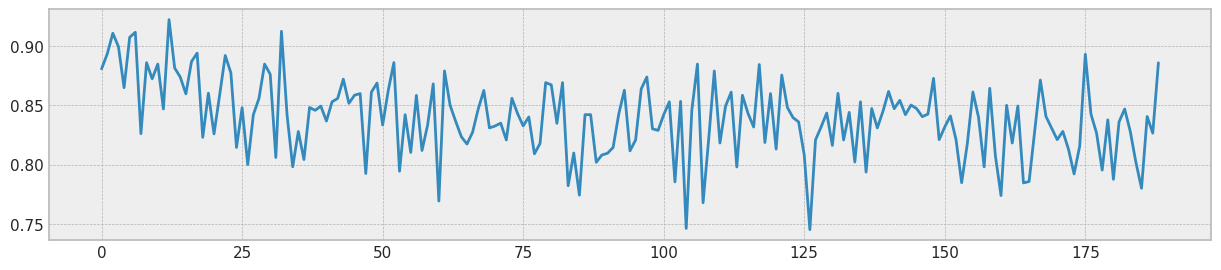

Mean F1 for all data: 0.8394016340345385
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 3.831744] [G loss: 0.692209]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 0.035031] [G loss: 0.677567]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 0.002750] [G loss: 0.645017]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 0.002744] [G loss: 0.608446]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 0.004944] [G loss: 0.568062]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 0.007613] [G loss: 0.526155]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 0.010289] [G loss: 0.483610]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 0.012785] [G loss: 0.441011]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 0.014884] [G loss: 0.401074]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 0.015470] [G loss: 0.367311]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 0.014921] [G loss: 0.339628]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 0.013580] [G loss: 0.317693]
[Lambda: 0.500000] [Epoch 2400/4000] [mi loss: 0.01176

100%|██████████| 189/189 [00:00<00:00, 384.25it/s]


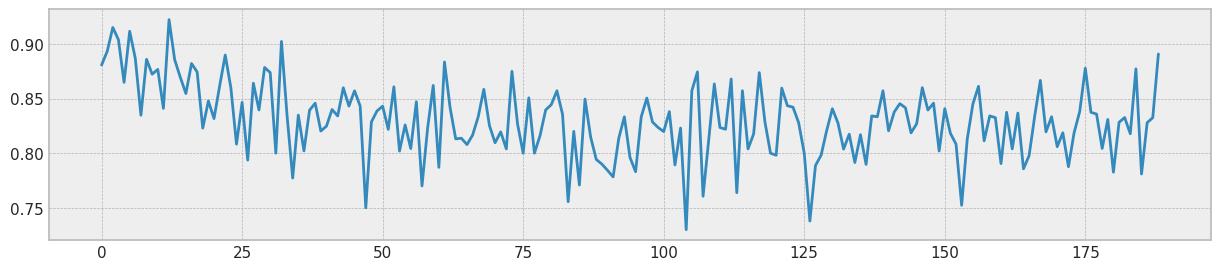

Mean F1 for all data: 0.830316738688078
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 3.831744] [G loss: 0.692209]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 0.034826] [G loss: 0.677662]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 0.002420] [G loss: 0.645533]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: 0.001522] [G loss: 0.610282]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: 0.002439] [G loss: 0.571849]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: 0.003548] [G loss: 0.532100]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 0.004752] [G loss: 0.491796]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: 0.006082] [G loss: 0.450951]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: 0.007151] [G loss: 0.412140]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: 0.007718] [G loss: 0.377289]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: 0.007471] [G loss: 0.348060]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: 0.006858] [G loss: 0.324494]
[Lambda: 0.600000] [Epoch 2400/4000] [mi loss: 0.005943

100%|██████████| 189/189 [00:00<00:00, 375.63it/s]


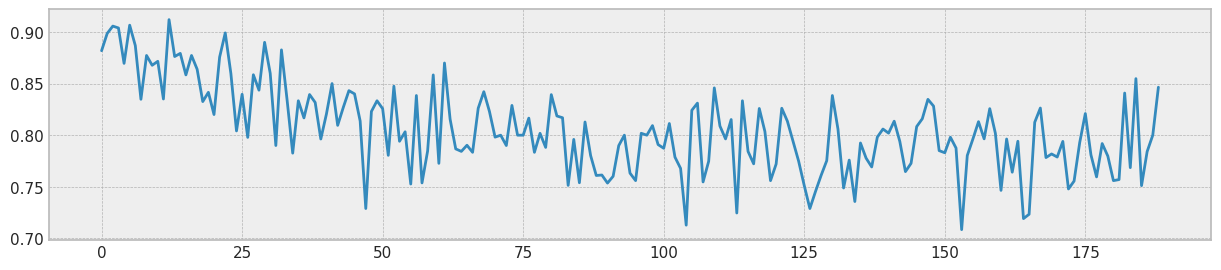

Mean F1 for all data: 0.8057890497262843
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 3.831744] [G loss: 0.692209]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 0.034691] [G loss: 0.677733]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 0.002267] [G loss: 0.645895]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: 0.000973] [G loss: 0.611534]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: 0.001169] [G loss: 0.574654]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 0.001599] [G loss: 0.536476]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 0.002105] [G loss: 0.497676]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 0.002659] [G loss: 0.458377]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: 0.003084] [G loss: 0.420744]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 0.003380] [G loss: 0.385835]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 0.003328] [G loss: 0.355381]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 0.003065] [G loss: 0.330695]
[Lambda: 0.700000] [Epoch 2400/4000] [mi loss: 0.00269

100%|██████████| 189/189 [00:00<00:00, 362.42it/s]


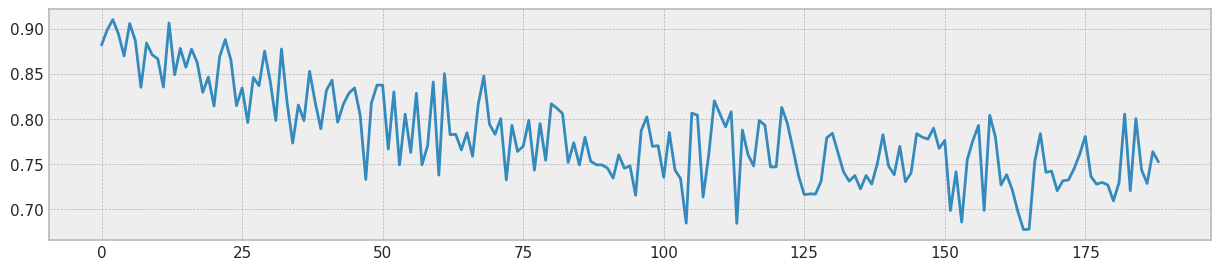

Mean F1 for all data: 0.78253029246326
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 3.831744] [G loss: 0.692209]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 0.034596] [G loss: 0.677787]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 0.002197] [G loss: 0.646171]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: 0.000716] [G loss: 0.612484]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: 0.000607] [G loss: 0.576670]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: 0.000678] [G loss: 0.539773]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 0.000801] [G loss: 0.502348]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: 0.000982] [G loss: 0.464360]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: 0.001141] [G loss: 0.427376]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: 0.001241] [G loss: 0.392798]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: 0.001233] [G loss: 0.361728]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: 0.001134] [G loss: 0.336083]
[Lambda: 0.800000] [Epoch 2400/4000] [mi loss: 0.000990]

100%|██████████| 189/189 [00:00<00:00, 379.78it/s]


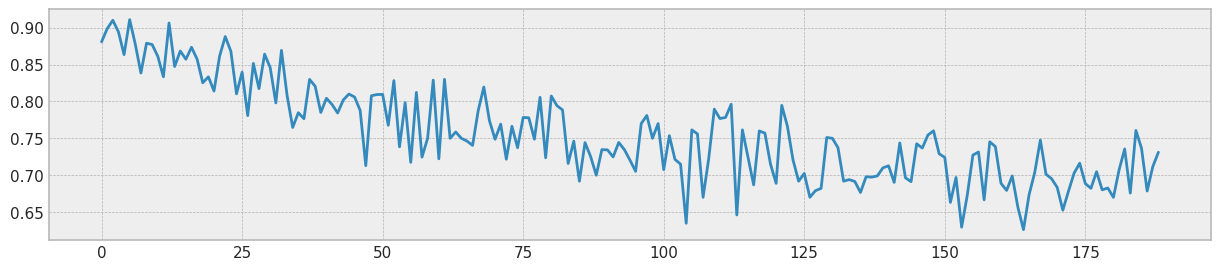

Mean F1 for all data: 0.7562684473794409
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 3.831744] [G loss: 0.692209]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 0.034527] [G loss: 0.677832]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 0.002169] [G loss: 0.646394]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: 0.000609] [G loss: 0.613235]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: 0.000380] [G loss: 0.578205]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: 0.000306] [G loss: 0.542267]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: 0.000281] [G loss: 0.505845]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 0.000289] [G loss: 0.468964]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: 0.000306] [G loss: 0.432718]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: 0.000315] [G loss: 0.398279]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: 0.000307] [G loss: 0.366838]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: 0.000282] [G loss: 0.340304]
[Lambda: 0.900000] [Epoch 2400/4000] [mi loss: 0.00024

100%|██████████| 189/189 [00:00<00:00, 407.54it/s]


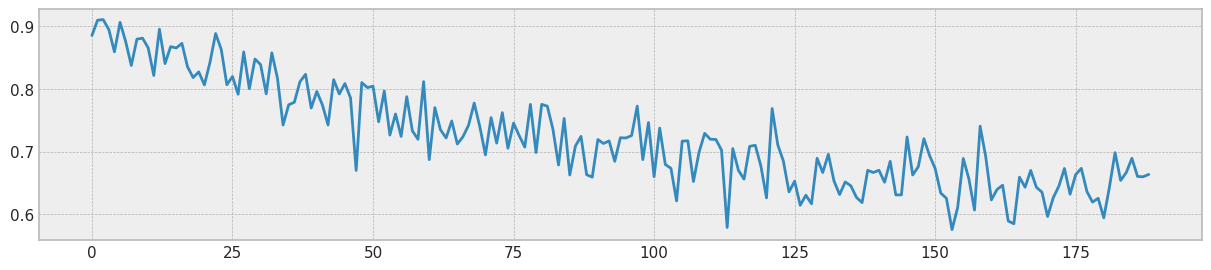

Mean F1 for all data: 0.7240072137331294


lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.000000
0                0.0  0.876404  0.894009  0.807732  0.795367  0.268953
1                0.1  0.875000  0.884793  0.617400  0.340741  0.238058
2                0.2  0.870056  0.885845  0.770005  0.682081  0.226700
3                0.3  0.865169  0.880734  0.643703  0.178862  0.231272
4                0.4  0.863636  0.880734  0.839402  0.885845  0.230132
5                0.5  0.863636  0.880734  0.830317  0.890830  0.230132
6                0.6  0.863636  0.881818  0.805789  0.846473  0.250217
7                0.7  0.868571  0.881818  0.782530  0.752066  0.245552
8                0.8  0.870056  0.880734  0.756268  0.731092  0.266231
9                0.9  0.881356  0.884793  0.724007  0.663636  0.259820

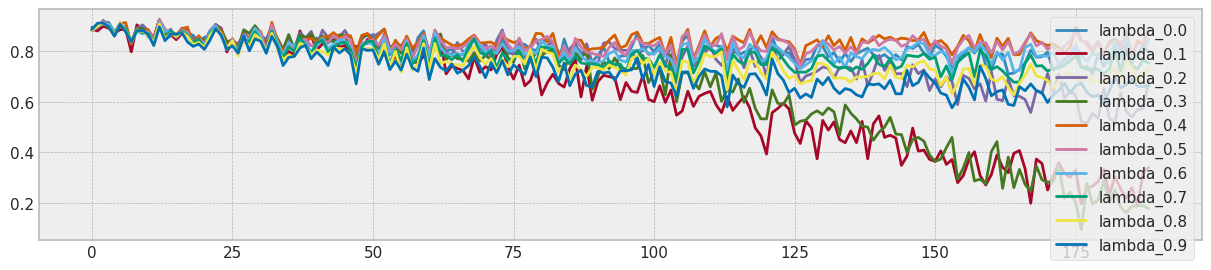

In [29]:
seed_everything()

train_result = []

avaible_range = 400

train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#lambda_f_set = [0.4,0.5]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.



#lambda_f_set2 = [0.0000089,0.0000090,0.0000091] 
lambda_f_set2 = [1.0] 
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    #lambda_a2 = lambda_f2

    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter = train_model(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= lambda_f2 )# 0.00057)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator,last_adapter,X[2000:][['x0','x1','x2','x3','z0','b']],y[2000:])

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3))
    #plt.show()
    result4_df = pd.DataFrame(result_table2)

    #print(lambda_f2,result4_df)

pd.concat([pd.DataFrame(result_table3),result4_df])

## synthetic data의 생성 (Case #2 MI의 증감(상대적), Drift의 고정)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature에 대해 y의 비중이 시간에 따라 감소하도록 생성

In [30]:
data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

In [31]:
seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

In [32]:
x1.shape

(40000, 5)

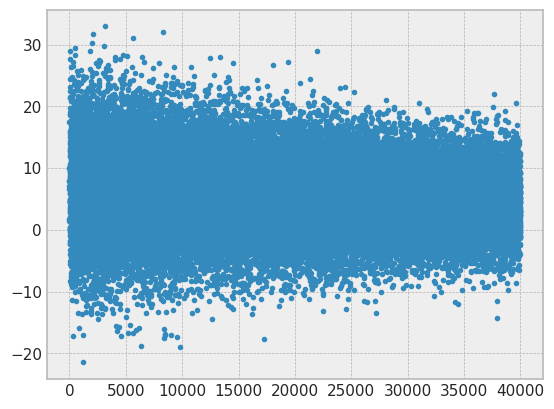

In [33]:
import matplotlib.pyplot as plt

seed_everything()

y1_array = []
cor_const = cor[4] 
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)
 
plt.plot(y1_array,'.')

In [34]:
y1 = [1 if y_ > 5 else 0 for y_ in y1_array]

In [35]:
sum(y1)

21325

In [36]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)
mi_scores = make_mi_scores(X1, y1, discrete_features="auto")
print(mi_scores)

x0    0.227465
z0    0.088169
x1    0.018550
x3    0.008429
x2    0.006772
Name: MI Scores, dtype: float64


Bucket size 10


100%|██████████| 10/10 [00:01<00:00,  9.94it/s]


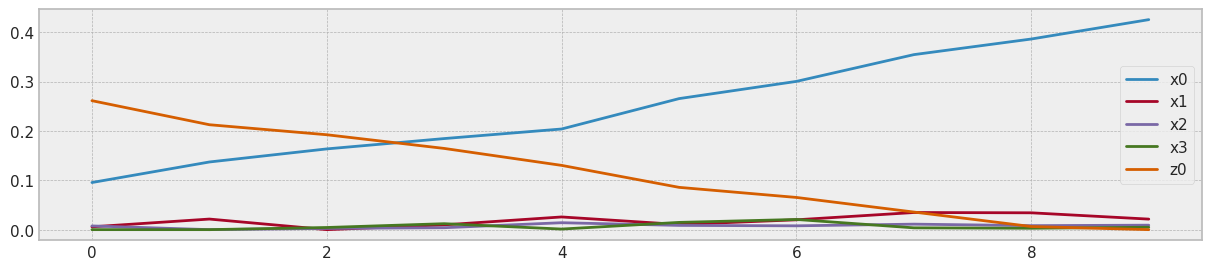

Bucket size 50


100%|██████████| 50/50 [00:01<00:00, 41.73it/s]


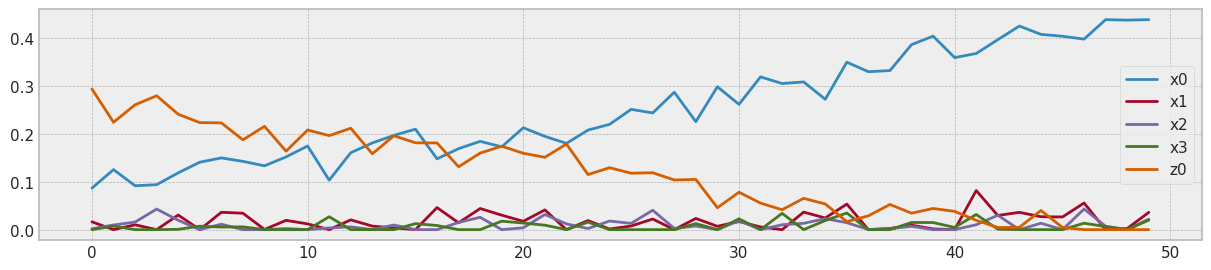

Bucket size 100


100%|██████████| 100/100 [00:01<00:00, 63.11it/s]


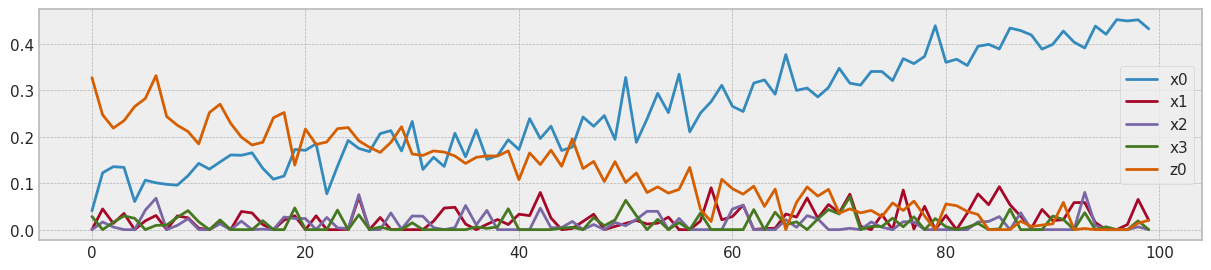

Bucket size 200


100%|██████████| 200/200 [00:02<00:00, 89.70it/s]


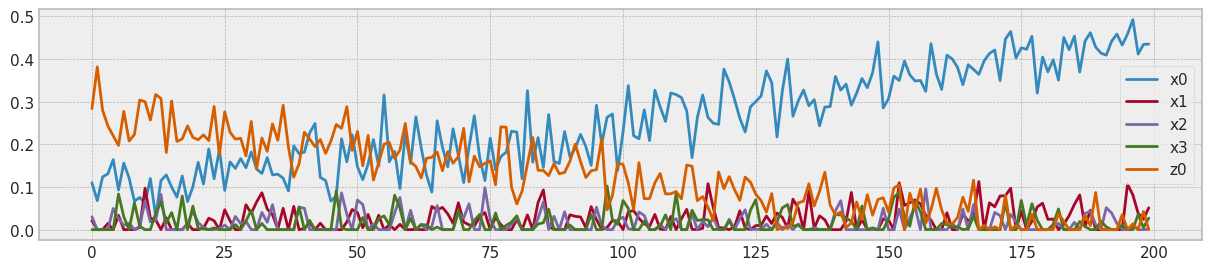

In [37]:
from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int(x1.shape[0]/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X1[bk*step_size:bk*step_size+step_size], y1[bk*step_size:bk*step_size+step_size], discrete_features="auto")
        for col in columns:
            MIS[col].append(mi_scores[col]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

Bucket size 10


100%|██████████| 10/10 [00:00<00:00, 273.17it/s]


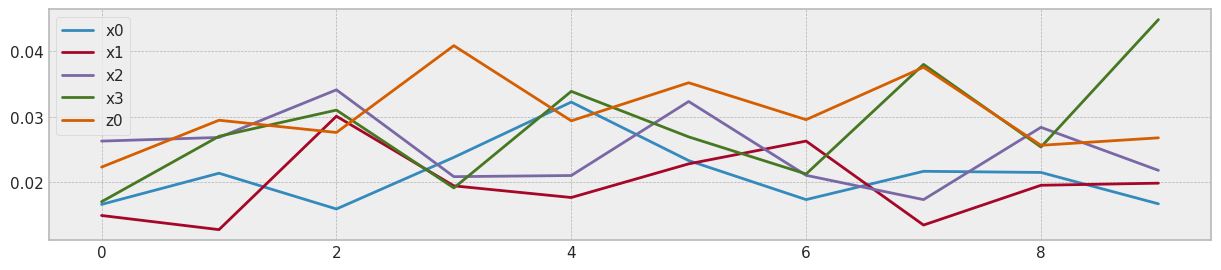

Bucket size 50


100%|██████████| 50/50 [00:00<00:00, 637.34it/s]


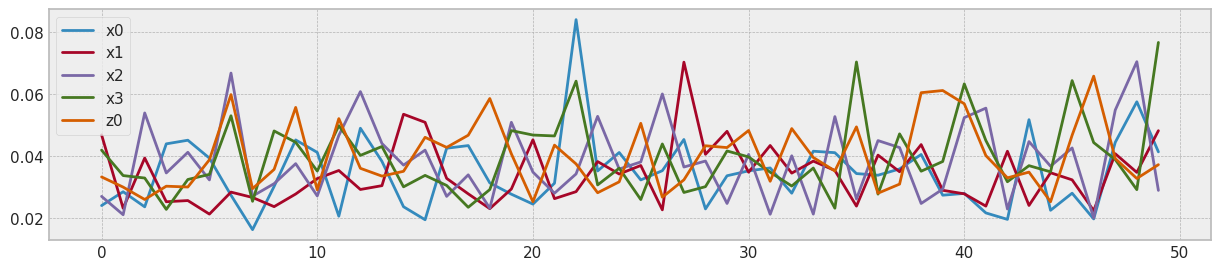

Bucket size 100


100%|██████████| 100/100 [00:00<00:00, 742.86it/s]


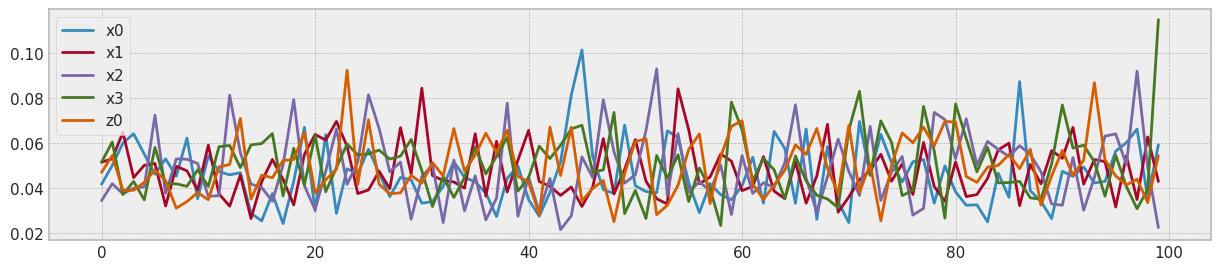

Bucket size 200


100%|██████████| 200/200 [00:00<00:00, 712.64it/s]


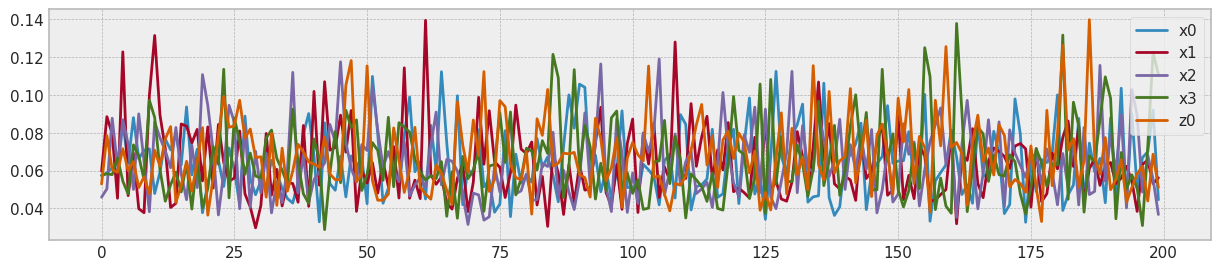

In [38]:
from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int((x.shape[0]-2000)/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)

        ks = __ks_drift(X1[0:1800].values,X1[bk*step_size+2000:bk*step_size+step_size+2000].values)
        #print(ks[:,0])
        for ix,col in enumerate(columns):
            MIS[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

## 학습 및 전체 예측

100%|██████████| 1000/1000 [00:20<00:00, 48.32it/s]


MSE: 0.04
RMSE: 0.19


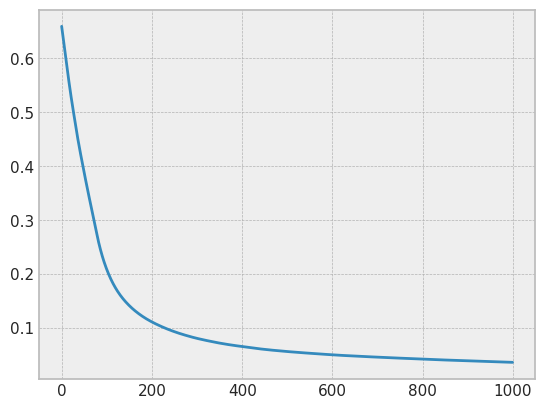

In [39]:
import copy
import torch.optim as optim
 
seed_everything()

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X1[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32)
y_train = torch.tensor(y1[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X1[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32)
y_test = torch.tensor(y1[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

100%|██████████| 189/189 [00:00<00:00, 484.97it/s]


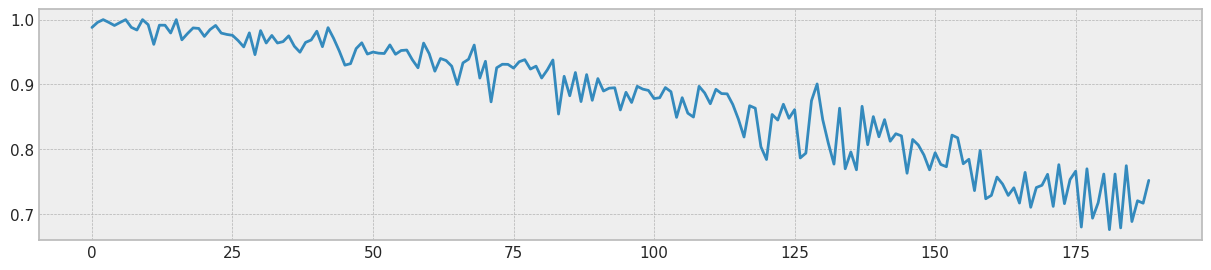

{'lambda': ['Case #1 Feature 5', 'Case #2 Feature 5'], 'test_f1': [0.8685714285714285, 0.8813559322033897], 'init_f1': [0.8899082568807338, 0.9879518072289156], 'mean_f1': [0.7058765598487894, 0.8771029636619416], 'last_f1': [0.6238532110091742, 0.7521367521367522], 'MI(y^,z)': [0.0, 0.0]}


In [40]:
XT = X1[2000:][['x0','x1','x2','x3','z0']]
yT = y1[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.show()

result_table3['lambda'].append('Case #2 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

print(result_table3)

In [41]:
pd.DataFrame(result_table3)

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853       0.0
1  Case #2 Feature 5  0.881356  0.987952  0.877103  0.752137       0.0

In [42]:
X1['b'] = [int(b) for b in X1.index.values]
X1

x0        x1        x2        x3        z0      b
0      1.877314  1.185467 -0.002710  1.124792 -1.925585      0
1      2.846794  0.461018  1.213784  1.282154  3.281450      1
2      2.232850  0.876278  2.307393  2.019052  0.187403      2
3     -0.198843  2.579531  0.078102  1.019118  2.385340      3
4      1.618080  1.683218  1.826908  0.697273  0.195648      4
...         ...       ...       ...       ...       ...    ...
39995 -0.321489  0.268097 -0.178799  1.410070  4.096949  39995
39996 -0.037401  1.055617  0.084065  1.252068  3.850920  39996
39997  2.262545 -0.256564  1.445491  1.256208  0.498200  39997
39998  0.823467  1.489013 -0.191516 -0.238143  5.022454  39998
39999  2.024101  2.498025  0.198514  2.241146  0.816579  39999

[40000 rows x 6 columns]

[Lambda: 0.000000] [Epoch 0/4000] [mi loss: 3.579481] [G loss: 0.691920]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss: 31.977556] [G loss: 0.535913]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss: 167.520065] [G loss: 0.263343]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss: 367.819519] [G loss: 0.137025]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss: 527.892578] [G loss: 0.085224]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss: 743.982422] [G loss: 0.054594]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss: 1004.055786] [G loss: 0.039535]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss: 1254.314087] [G loss: 0.030520]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss: 1504.760010] [G loss: 0.024546]
[Lambda: 0.000000] [Epoch 1800/4000] [mi loss: 1729.840332] [G loss: 0.020212]
[Lambda: 0.000000] [Epoch 2000/4000] [mi loss: 1958.711792] [G loss: 0.016945]
[Lambda: 0.000000] [Epoch 2200/4000] [mi loss: 2192.623047] [G loss: 0.014307]
[Lambda: 0.000000] [Epoch 2400/4000] [mi loss: 2435.114014] [G loss:

100%|██████████| 189/189 [00:00<00:00, 374.08it/s]


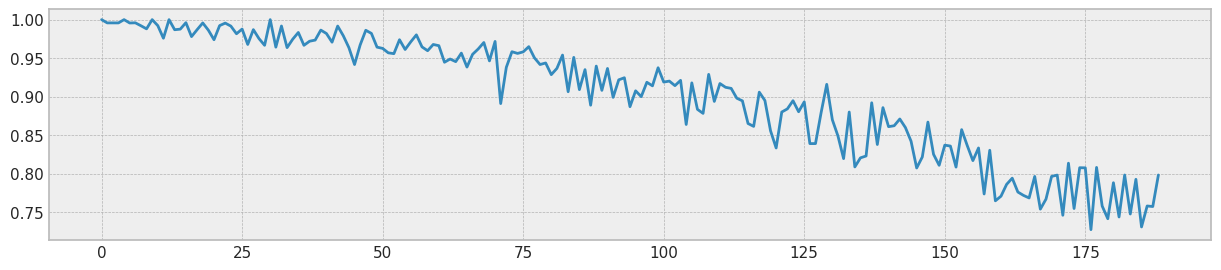

Mean F1 for all data: 0.9020893287409077
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 3.579481] [G loss: 0.691920]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 0.038438] [G loss: 0.682408]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 0.020403] [G loss: 0.637417]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: 0.059746] [G loss: 0.562696]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: 0.127424] [G loss: 0.467350]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: 0.193264] [G loss: 0.374916]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 0.225182] [G loss: 0.294600]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: 0.223729] [G loss: 0.237840]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: 0.212145] [G loss: 0.197976]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: 0.204410] [G loss: 0.167868]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: 0.197813] [G loss: 0.144908]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: 0.193279] [G loss: 0.126669]
[Lambda: 0.100000] [Epoch 2400/4000] [mi loss: 0.18789

100%|██████████| 189/189 [00:00<00:00, 373.28it/s]


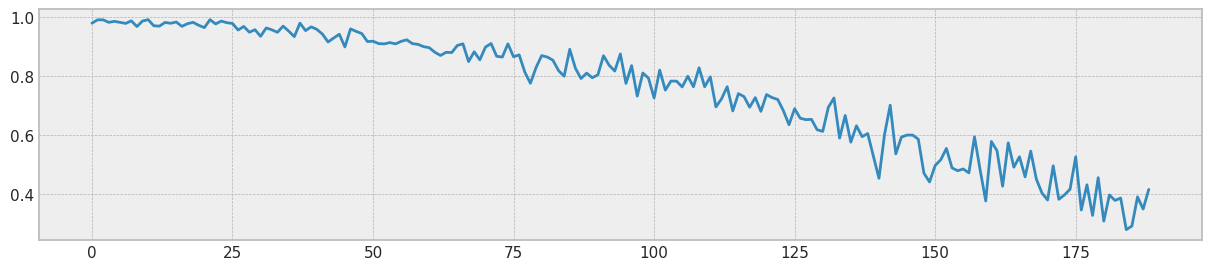

Mean F1 for all data: 0.7523799112336566
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 3.579481] [G loss: 0.691920]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 0.039501] [G loss: 0.682919]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 0.010173] [G loss: 0.639764]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 0.014513] [G loss: 0.572687]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: 0.030548] [G loss: 0.486440]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 0.051610] [G loss: 0.399927]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: 0.067744] [G loss: 0.320434]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: 0.072144] [G loss: 0.260960]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: 0.070966] [G loss: 0.218564]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: 0.068898] [G loss: 0.187377]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: 0.067134] [G loss: 0.163561]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: 0.065604] [G loss: 0.144790]
[Lambda: 0.200000] [Epoch 2400/4000] [mi loss: 0.06430

100%|██████████| 189/189 [00:00<00:00, 367.92it/s]


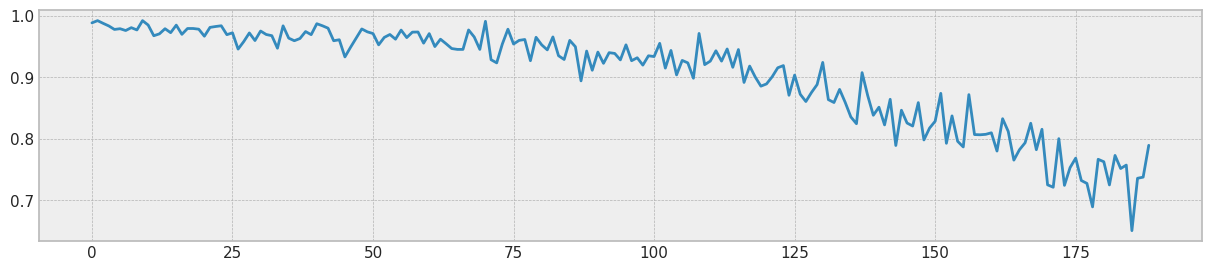

Mean F1 for all data: 0.9031849904055594
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 3.579481] [G loss: 0.691920]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 0.040122] [G loss: 0.683104]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 0.008774] [G loss: 0.640535]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 0.007051] [G loss: 0.576025]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: 0.011924] [G loss: 0.493918]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: 0.019999] [G loss: 0.412130]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: 0.028096] [G loss: 0.334992]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: 0.030976] [G loss: 0.274977]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: 0.031396] [G loss: 0.231067]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: 0.030964] [G loss: 0.198635]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: 0.030365] [G loss: 0.174074]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: 0.029638] [G loss: 0.154795]
[Lambda: 0.300000] [Epoch 2400/4000] [mi loss: 0.02922

100%|██████████| 189/189 [00:00<00:00, 371.62it/s]


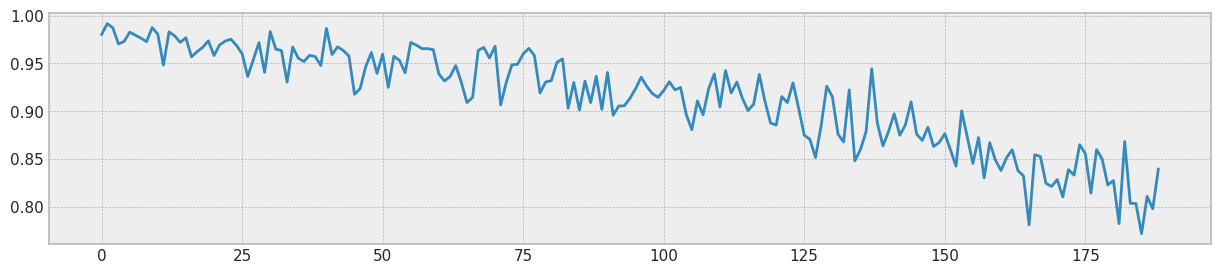

Mean F1 for all data: 0.9134265305529544
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 3.579481] [G loss: 0.691920]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 0.040504] [G loss: 0.683184]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 0.008443] [G loss: 0.640908]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 0.004825] [G loss: 0.577639]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 0.005862] [G loss: 0.497897]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 0.009269] [G loss: 0.418919]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 0.012915] [G loss: 0.344094]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 0.014768] [G loss: 0.284225]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 0.015177] [G loss: 0.239872]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 0.015213] [G loss: 0.206821]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 0.015050] [G loss: 0.181738]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 0.014756] [G loss: 0.162051]
[Lambda: 0.400000] [Epoch 2400/4000] [mi loss: 0.01463

100%|██████████| 189/189 [00:00<00:00, 355.09it/s]


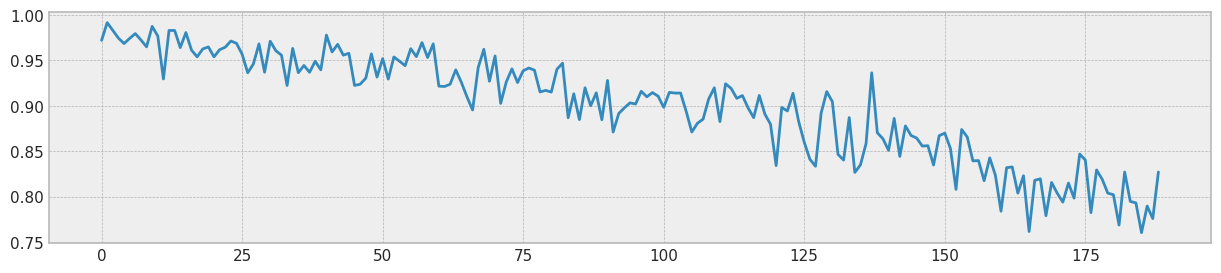

Mean F1 for all data: 0.8996639201352484
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 3.579481] [G loss: 0.691920]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 0.040753] [G loss: 0.683241]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 0.008363] [G loss: 0.641139]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 0.003968] [G loss: 0.578629]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 0.003339] [G loss: 0.500386]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 0.004638] [G loss: 0.423338]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 0.006367] [G loss: 0.350098]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 0.007215] [G loss: 0.290810]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 0.007467] [G loss: 0.246266]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 0.007598] [G loss: 0.212859]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 0.007570] [G loss: 0.187369]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 0.007534] [G loss: 0.167334]
[Lambda: 0.500000] [Epoch 2400/4000] [mi loss: 0.00747

100%|██████████| 189/189 [00:00<00:00, 368.54it/s]


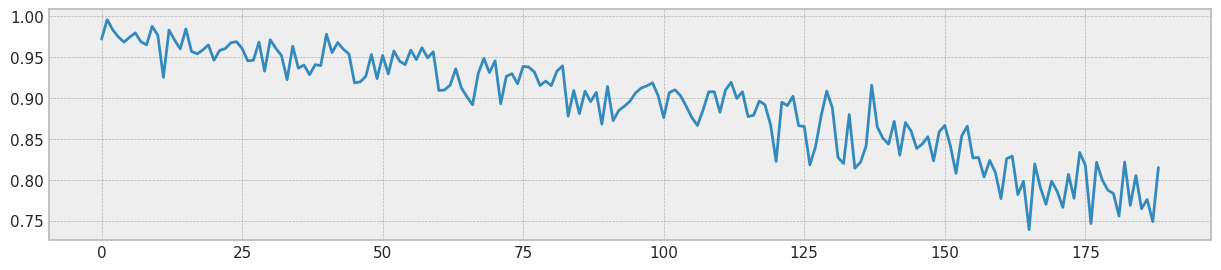

Mean F1 for all data: 0.892279187066622
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 3.579481] [G loss: 0.691920]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 0.040931] [G loss: 0.683280]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 0.008358] [G loss: 0.641298]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: 0.003597] [G loss: 0.579293]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: 0.002190] [G loss: 0.502086]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: 0.002441] [G loss: 0.426532]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 0.003143] [G loss: 0.354572]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: 0.003509] [G loss: 0.295661]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: 0.003661] [G loss: 0.251030]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: 0.003689] [G loss: 0.217520]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: 0.003696] [G loss: 0.191821]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: 0.003701] [G loss: 0.171703]
[Lambda: 0.600000] [Epoch 2400/4000] [mi loss: 0.003727

100%|██████████| 189/189 [00:00<00:00, 379.41it/s]


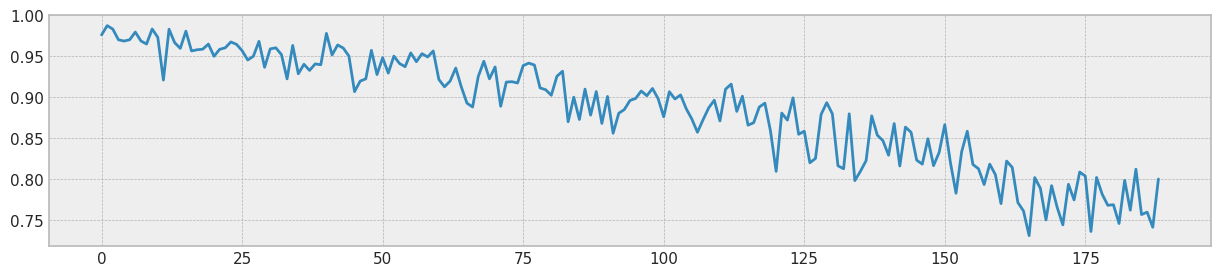

Mean F1 for all data: 0.8855251787858447
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 3.579481] [G loss: 0.691920]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 0.041064] [G loss: 0.683304]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 0.008381] [G loss: 0.641410]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: 0.003431] [G loss: 0.579777]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: 0.001632] [G loss: 0.503326]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 0.001352] [G loss: 0.428904]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 0.001538] [G loss: 0.357953]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 0.001668] [G loss: 0.299361]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: 0.001719] [G loss: 0.254772]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 0.001713] [G loss: 0.221206]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 0.001731] [G loss: 0.195437]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 0.001735] [G loss: 0.175258]
[Lambda: 0.700000] [Epoch 2400/4000] [mi loss: 0.00174

100%|██████████| 189/189 [00:00<00:00, 359.54it/s]


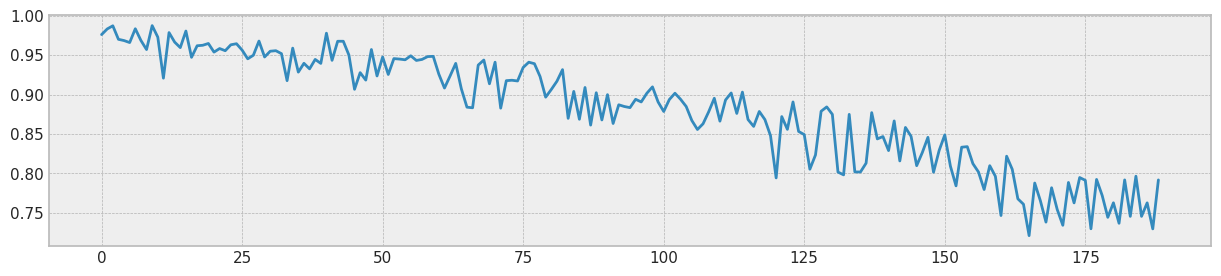

Mean F1 for all data: 0.8812246592832119
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 3.579481] [G loss: 0.691920]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 0.041205] [G loss: 0.683321]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 0.008418] [G loss: 0.641490]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: 0.003362] [G loss: 0.580163]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: 0.001360] [G loss: 0.504286]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: 0.000824] [G loss: 0.430727]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 0.000743] [G loss: 0.360624]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: 0.000734] [G loss: 0.302365]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: 0.000714] [G loss: 0.257880]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: 0.000698] [G loss: 0.224289]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: 0.000696] [G loss: 0.198555]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: 0.000684] [G loss: 0.178434]
[Lambda: 0.800000] [Epoch 2400/4000] [mi loss: 0.00069

100%|██████████| 189/189 [00:00<00:00, 360.54it/s]


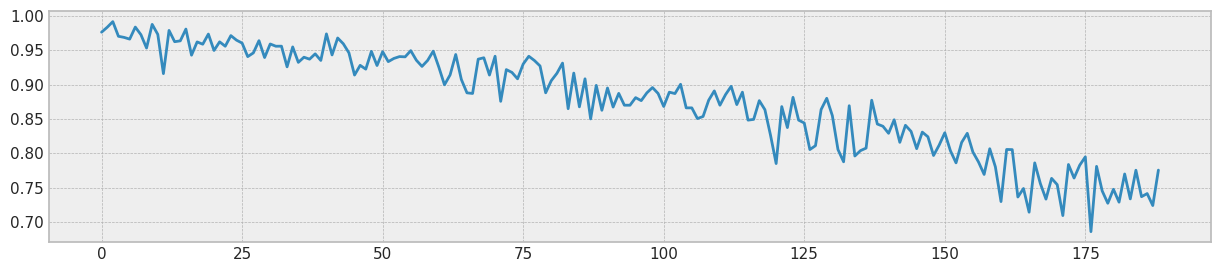

Mean F1 for all data: 0.875554900019738
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 3.579481] [G loss: 0.691920]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 0.041288] [G loss: 0.683335]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 0.008450] [G loss: 0.641547]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: 0.003339] [G loss: 0.580450]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: 0.001236] [G loss: 0.505025]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: 0.000587] [G loss: 0.432191]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: 0.000393] [G loss: 0.362794]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 0.000316] [G loss: 0.304856]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: 0.000272] [G loss: 0.260416]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: 0.000242] [G loss: 0.226866]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: 0.000221] [G loss: 0.201175]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: 0.000207] [G loss: 0.181052]
[Lambda: 0.900000] [Epoch 2400/4000] [mi loss: 0.000197

100%|██████████| 189/189 [00:00<00:00, 361.21it/s]


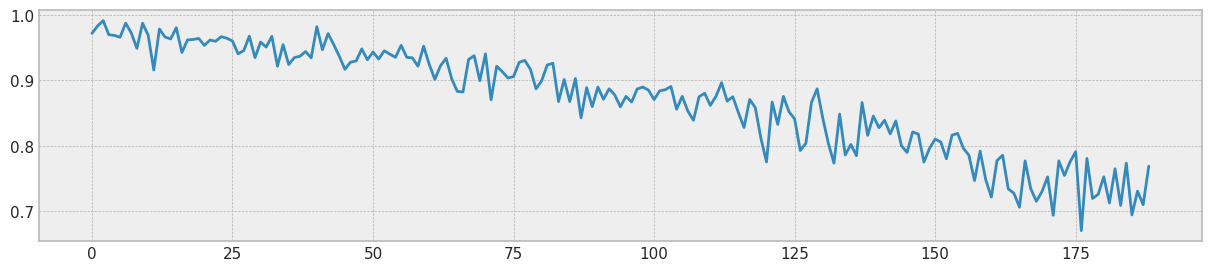

Mean F1 for all data: 0.8700408533304335


lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.000000
1  Case #2 Feature 5  0.881356  0.987952  0.877103  0.752137  0.000000
0                0.0  0.991071  1.000000  0.902089  0.798246  0.287362
1                0.1  0.978355  0.980237  0.752380  0.415385  0.321897
2                0.2  0.978355  0.988048  0.903185  0.789189  0.321897
3                0.3  0.982609  0.980080  0.913427  0.839827  0.322423
4                0.4  0.978355  0.972112  0.899664  0.827004  0.309336
5                0.5  0.974138  0.972112  0.892279  0.814815  0.297363
6                0.6  0.974138  0.976190  0.885525  0.800000  0.297363
7                0.7  0.965517  0.976190  0.881225  0.791837  0.279941
8                0.8  0.965517  0.976190  0.875555  0.775510  0.279941
9                0.9  0.961373  0.972112  0.870041  0.768595  0.283400

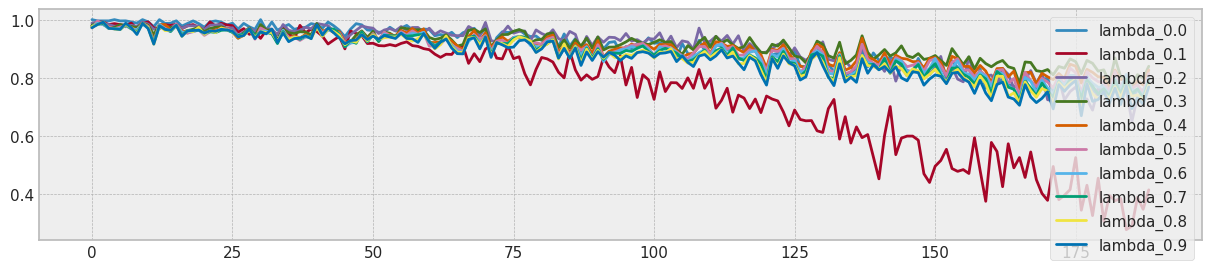

In [43]:
seed_everything()

train_result = []

avaible_range = 40000 

train_tensors = Namespace(XS_train = torch.tensor(X1[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y1[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X1[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X1[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y1[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X1[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X1[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y1[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X1[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X1[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y1[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X1[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#lambda_f_set = [0.4,0.5]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.



#lambda_f_set2 = [0.0000089,0.0000090,0.0000091] 
lambda_f_set2 = [1.0] 
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    #lambda_a2 = lambda_f2

    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter = train_model(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= lambda_f2 )# 0.00057)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator,last_adapter,X1[2000:][['x0','x1','x2','x3','z0','b']],y1[2000:])

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3))
    #plt.show()
    result4_df = pd.DataFrame(result_table2)

    #print(lambda_f2,result4_df)

pd.concat([pd.DataFrame(result_table3),result4_df])

## synthetic data의 생성 (Case #3 MI의 고정, Drift의 증가)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift, MI는 고정

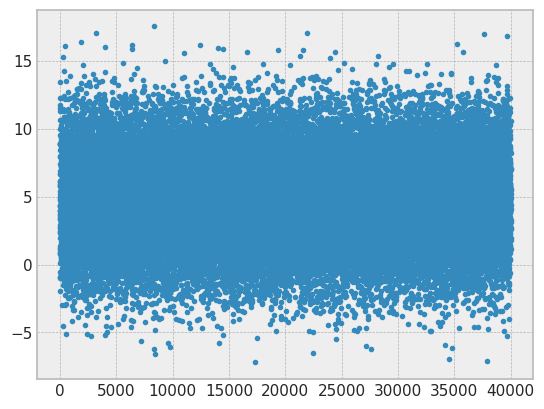

In [44]:
import matplotlib.pyplot as plt

seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

x2 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x2[:,ix] = np.random.normal(1,cor_,data_size)

y2_array = [] 
cor_const = 3/x2.shape[0]
for ii in range(x2.shape[0]):
    e = np.random.normal(0.0, cor_const * ii)
    x2[ii,4] = x2[ii,4] + e
    y2_array.append(np.sum(cor * x1[ii]))
 
plt.plot(y2_array,'.')

In [45]:
y2 = [1 if y_ > 5 else 0 for y_ in y2_array]

In [46]:
sum(y2)

19015

In [47]:
columns=['x0','x1','x2','x3','z0']
X2 = pd.DataFrame(x2,columns=columns)
mi_scores = make_mi_scores(X2, y2, discrete_features="auto")
print(mi_scores)

x0    0.199733
x1    0.070473
x2    0.020851
x3    0.014964
z0    0.006106
Name: MI Scores, dtype: float64


Bucket size 10


100%|██████████| 10/10 [00:00<00:00, 10.06it/s]


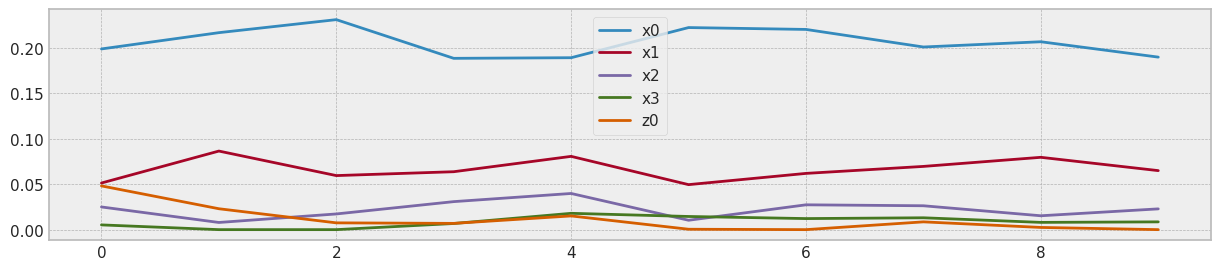

Bucket size 50


100%|██████████| 50/50 [00:01<00:00, 41.04it/s]


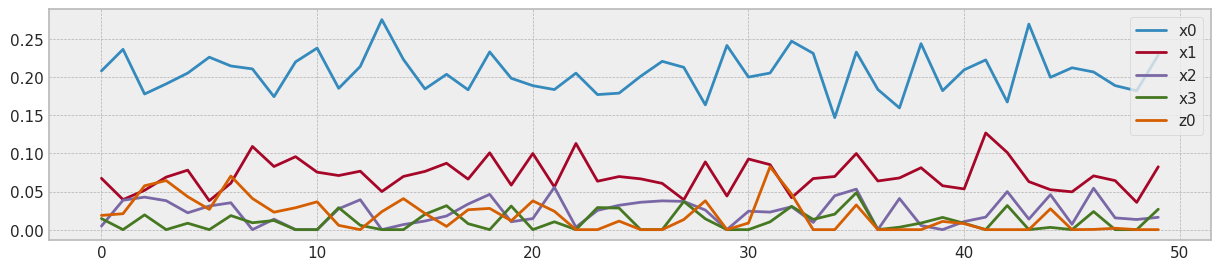

Bucket size 100


100%|██████████| 100/100 [00:01<00:00, 63.21it/s]


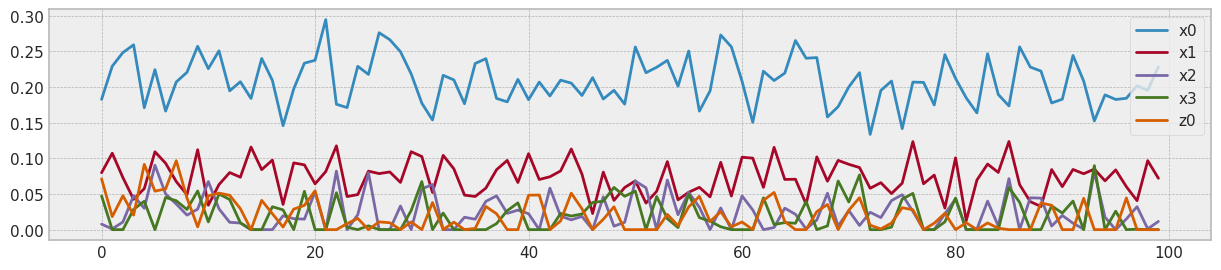

Bucket size 200


100%|██████████| 200/200 [00:02<00:00, 90.38it/s]


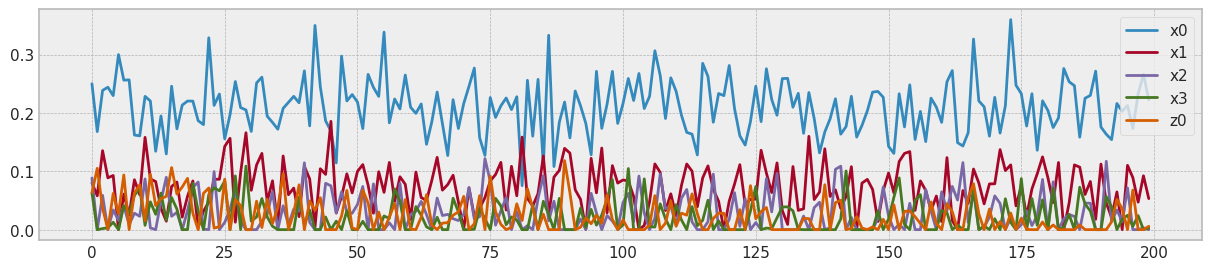

In [48]:
from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int(x1.shape[0]/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X2[bk*step_size:bk*step_size+step_size], y2[bk*step_size:bk*step_size+step_size], discrete_features="auto")
        for col in columns:
            MIS[col].append(mi_scores[col]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

Bucket size 10


100%|██████████| 10/10 [00:00<00:00, 260.91it/s]


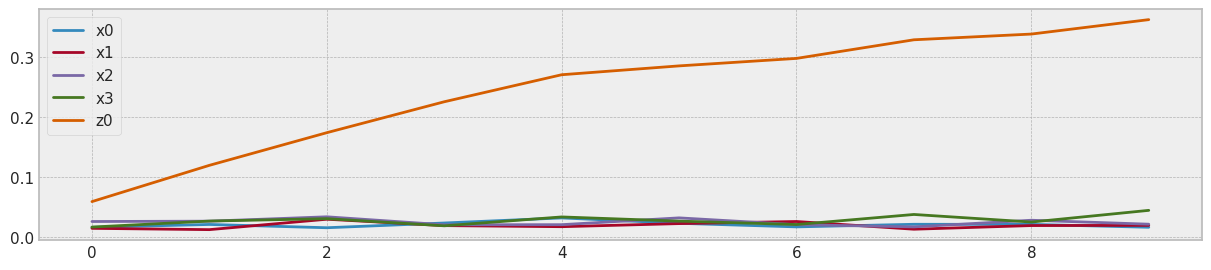

Bucket size 50


100%|██████████| 50/50 [00:00<00:00, 633.98it/s]


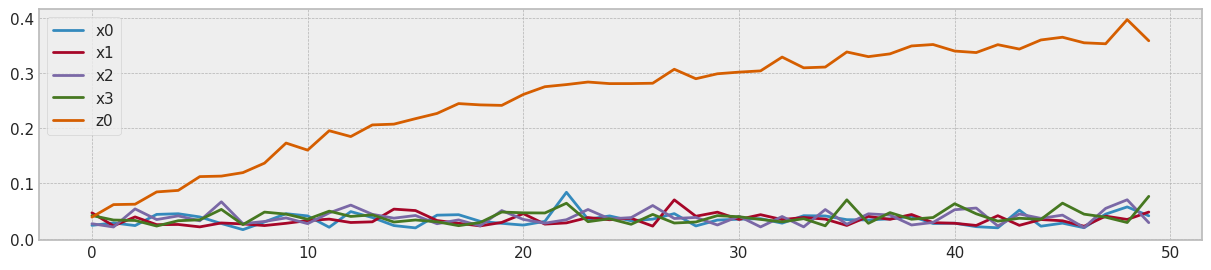

Bucket size 100


100%|██████████| 100/100 [00:00<00:00, 666.03it/s]


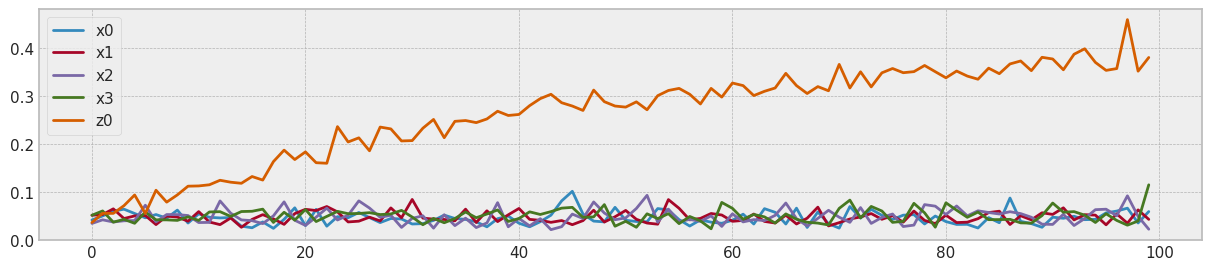

Bucket size 200


100%|██████████| 200/200 [00:00<00:00, 798.02it/s]


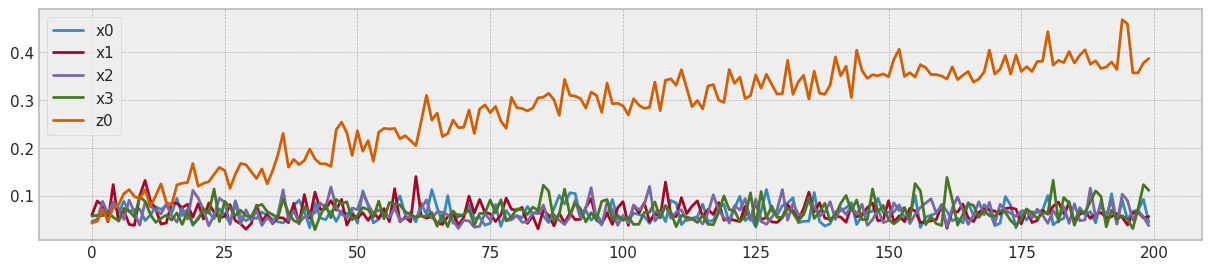

In [49]:
from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int((x.shape[0]-2000)/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)

        ks = __ks_drift(X2[0:1800].values,X2[bk*step_size+2000:bk*step_size+step_size+2000].values)
        #print(ks[:,0])
        for ix,col in enumerate(columns):
            MIS[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

## 학습 및 전체 예측

100%|██████████| 1000/1000 [00:20<00:00, 48.07it/s]


MSE: 0.09
RMSE: 0.31


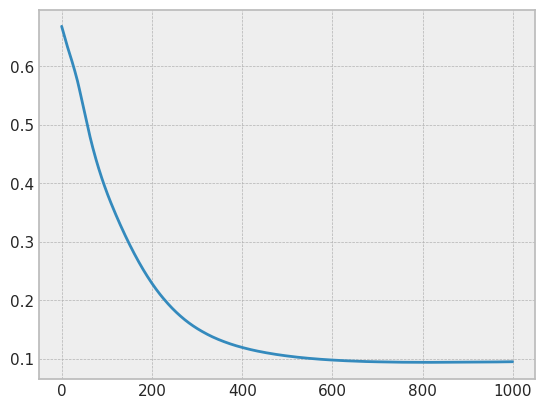

In [50]:
import copy
import torch.optim as optim
 
seed_everything()

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32)
y_train = torch.tensor(y2[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32)
y_test = torch.tensor(y2[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

100%|██████████| 189/189 [00:00<00:00, 522.25it/s]


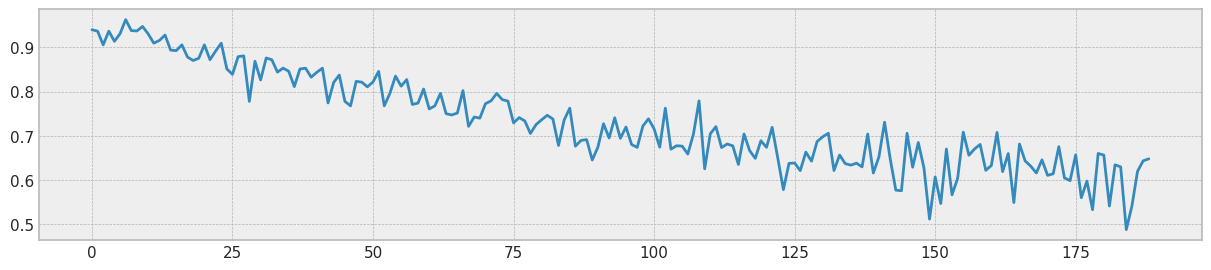

{'lambda': ['Case #1 Feature 5', 'Case #2 Feature 5', 'Case #3 Feature 5'], 'test_f1': [0.8685714285714285, 0.8813559322033897, 0.9613733905579399], 'init_f1': [0.8899082568807338, 0.9879518072289156, 0.9393939393939393], 'mean_f1': [0.7058765598487894, 0.8771029636619416, 0.7319166135663664], 'last_f1': [0.6238532110091742, 0.7521367521367522, 0.6481481481481481], 'MI(y^,z)': [0.0, 0.0, 0.005726817196822331]}


In [51]:
XT = X2[2000:][['x0','x1','x2','x3','z0']]
yT = y2[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.show()

result_table3['lambda'].append('Case #3 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

print(result_table3)

In [52]:
pd.DataFrame(result_table3)

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.000000
1  Case #2 Feature 5  0.881356  0.987952  0.877103  0.752137  0.000000
2  Case #3 Feature 5  0.961373  0.939394  0.731917  0.648148  0.005727

## Case #3의 feature 4

100%|██████████| 1000/1000 [00:20<00:00, 48.10it/s]


MSE: 0.30
RMSE: 0.55


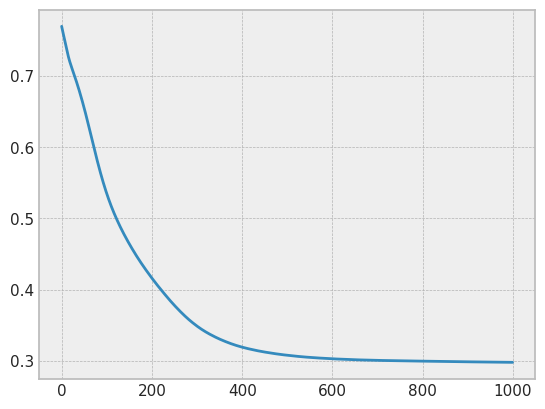

In [53]:
import copy
import torch.optim as optim
 
seed_everything()

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3']].values, dtype=torch.float32)
y_train = torch.tensor(y2[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3']].values, dtype=torch.float32)
y_test = torch.tensor(y2[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(4, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

100%|██████████| 189/189 [00:00<00:00, 536.22it/s]


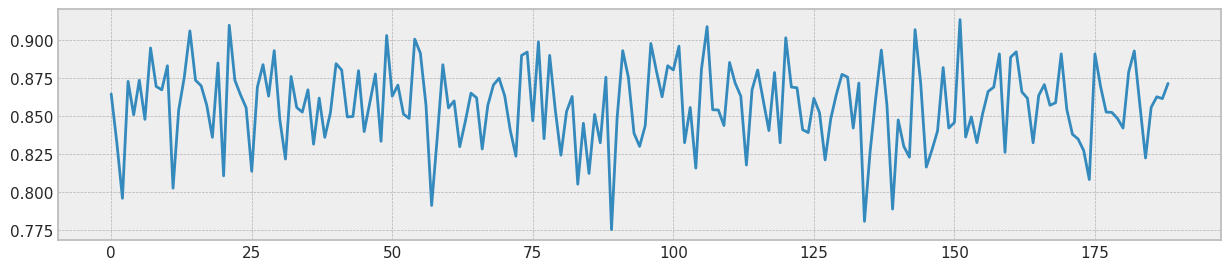

{'lambda': ['Case #1 Feature 5', 'Case #2 Feature 5', 'Case #3 Feature 5', 'Case #3 Feature 4'], 'test_f1': [0.8685714285714285, 0.8813559322033897, 0.9613733905579399, 0.9613733905579399], 'init_f1': [0.8899082568807338, 0.9879518072289156, 0.9393939393939393, 0.8645833333333334], 'mean_f1': [0.7058765598487894, 0.8771029636619416, 0.7319166135663664, 0.8572184847435292], 'last_f1': [0.6238532110091742, 0.7521367521367522, 0.6481481481481481, 0.8715596330275229], 'MI(y^,z)': [0.0, 0.0, 0.005726817196822331, 0.005726817196822331]}


In [54]:
XT = X2[2000:][['x0','x1','x2','x3']]
yT = y2[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.show()

result_table3['lambda'].append('Case #3 Feature 4')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

print(result_table3)

In [55]:
pd.DataFrame(result_table3)

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.000000
1  Case #2 Feature 5  0.881356  0.987952  0.877103  0.752137  0.000000
2  Case #3 Feature 5  0.961373  0.939394  0.731917  0.648148  0.005727
3  Case #3 Feature 4  0.961373  0.864583  0.857218  0.871560  0.005727

In [56]:
X2['b'] = [int(b) for b in X2.index.values]
X2

x0        x1        x2        x3        z0      b
0      1.877314  1.185467 -0.002710  1.124792  0.414883      0
1      2.846794  0.461018  1.213784  1.282154  1.456334      1
2      2.232850  0.876278  2.307393  2.019052  0.837239      2
3     -0.198843  2.579531  0.078102  1.019118  1.277169      3
4      1.618080  1.683218  1.826908  0.697273  0.839361      4
...         ...       ...       ...       ...       ...    ...
39995 -0.321489  0.268097 -0.178799  1.410070 -2.562643  39995
39996 -0.037401  1.055617  0.084065  1.252068 -2.160164  39996
39997  2.262545 -0.256564  1.445491  1.256208  0.476012  39997
39998  0.823467  1.489013 -0.191516 -0.238143  2.303669  39998
39999  2.024101  2.498025  0.198514  2.241146  0.462217  39999

[40000 rows x 6 columns]

[Lambda: 0.000000] [Epoch 0/4000] [mi loss: 2.308876] [G loss: 0.692452]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss: 16.730021] [G loss: 0.628617]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss: 155.913055] [G loss: 0.400835]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss: 323.657837] [G loss: 0.212173]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss: 487.403625] [G loss: 0.123346]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss: 669.747437] [G loss: 0.086429]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss: 833.302917] [G loss: 0.069461]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss: 979.561646] [G loss: 0.059856]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss: 1113.369995] [G loss: 0.053495]
[Lambda: 0.000000] [Epoch 1800/4000] [mi loss: 1239.298706] [G loss: 0.049394]
[Lambda: 0.000000] [Epoch 2000/4000] [mi loss: 1355.595947] [G loss: 0.046354]
[Lambda: 0.000000] [Epoch 2200/4000] [mi loss: 1460.475830] [G loss: 0.044006]
[Lambda: 0.000000] [Epoch 2400/4000] [mi loss: 1550.853516] [G loss: 0

100%|██████████| 189/189 [00:00<00:00, 362.21it/s]


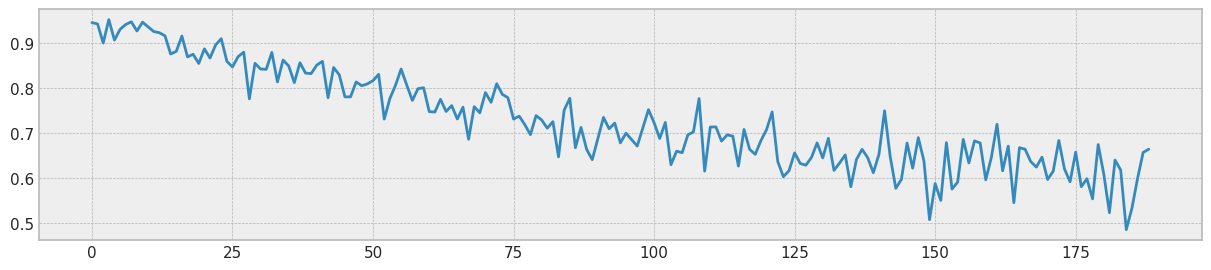

Mean F1 for all data: 0.7282731280847575
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 2.308876] [G loss: 0.692452]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 0.025784] [G loss: 0.675853]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 0.029383] [G loss: 0.642600]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: 0.061209] [G loss: 0.602394]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: 0.113863] [G loss: 0.544644]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: 0.175168] [G loss: 0.479893]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 0.222755] [G loss: 0.422215]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: 0.249364] [G loss: 0.377958]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: 0.252313] [G loss: 0.347509]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: 0.298728] [G loss: 0.316200]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: 0.447926] [G loss: 0.255126]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: 0.470958] [G loss: 0.213587]
[Lambda: 0.100000] [Epoch 2400/4000] [mi loss: 0.46472

100%|██████████| 189/189 [00:00<00:00, 372.48it/s]


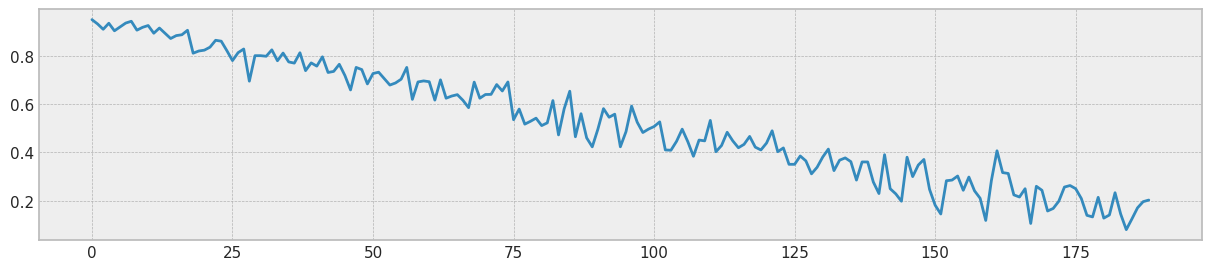

Mean F1 for all data: 0.5230588895932153
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 2.308876] [G loss: 0.692452]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 0.026319] [G loss: 0.677259]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 0.006497] [G loss: 0.647168]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 0.014671] [G loss: 0.611341]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: 0.029130] [G loss: 0.560671]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 0.048291] [G loss: 0.503370]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: 0.065377] [G loss: 0.449969]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: 0.077632] [G loss: 0.405669]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: 0.093626] [G loss: 0.366104]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: 0.113990] [G loss: 0.327900]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: 0.136327] [G loss: 0.290413]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: 0.152416] [G loss: 0.257451]
[Lambda: 0.200000] [Epoch 2400/4000] [mi loss: 0.15896

100%|██████████| 189/189 [00:00<00:00, 377.34it/s]


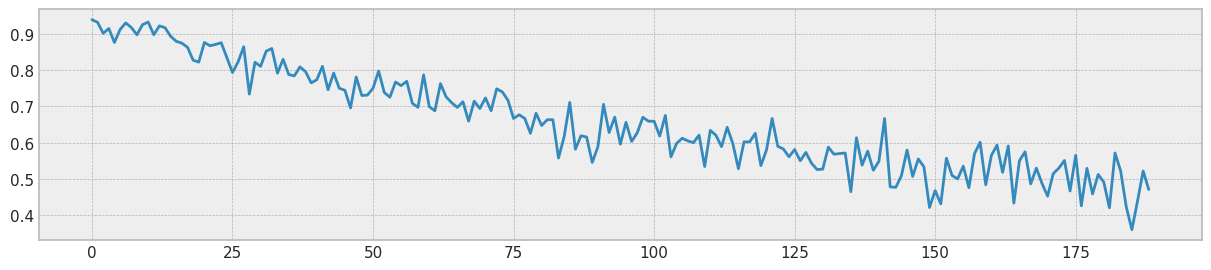

Mean F1 for all data: 0.6582723837566814
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 2.308876] [G loss: 0.692452]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 0.027442] [G loss: 0.677742]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 0.003144] [G loss: 0.648791]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 0.005856] [G loss: 0.614939]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: 0.011673] [G loss: 0.567809]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: 0.019506] [G loss: 0.514605]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: 0.025963] [G loss: 0.464284]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: 0.031292] [G loss: 0.421819]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: 0.036800] [G loss: 0.386002]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: 0.045199] [G loss: 0.352665]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: 0.055188] [G loss: 0.320116]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: 0.064984] [G loss: 0.288854]
[Lambda: 0.300000] [Epoch 2400/4000] [mi loss: 0.07198

100%|██████████| 189/189 [00:00<00:00, 378.51it/s]


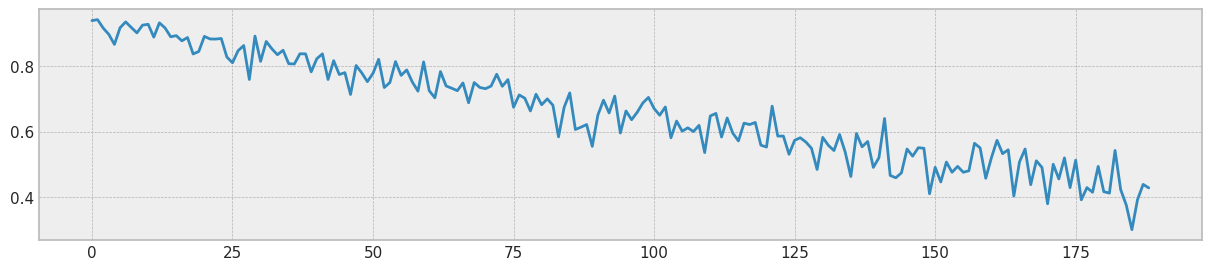

Mean F1 for all data: 0.6612942238892878
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 2.308876] [G loss: 0.692452]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 0.028173] [G loss: 0.677978]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 0.002297] [G loss: 0.649621]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 0.002979] [G loss: 0.616893]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 0.005474] [G loss: 0.571935]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 0.008938] [G loss: 0.521197]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 0.012126] [G loss: 0.472544]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 0.014790] [G loss: 0.431158]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 0.017269] [G loss: 0.397007]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 0.020712] [G loss: 0.366735]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 0.025007] [G loss: 0.337989]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 0.029805] [G loss: 0.309817]
[Lambda: 0.400000] [Epoch 2400/4000] [mi loss: 0.03435

100%|██████████| 189/189 [00:00<00:00, 375.25it/s]


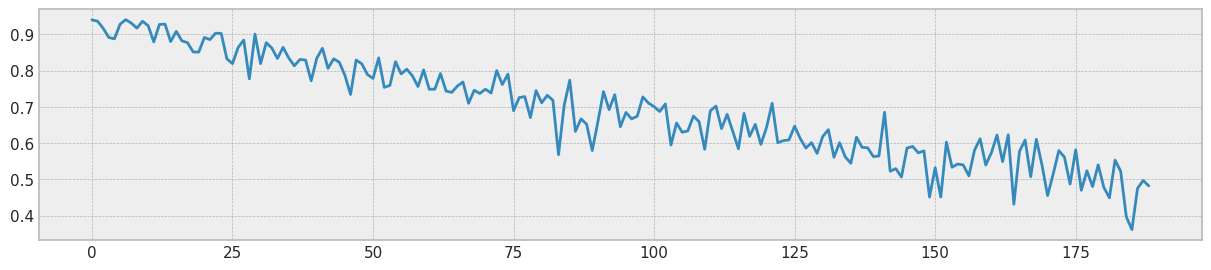

Mean F1 for all data: 0.6922104055104745
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 2.308876] [G loss: 0.692452]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 0.028679] [G loss: 0.678122]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 0.002055] [G loss: 0.650133]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 0.001813] [G loss: 0.618111]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 0.002850] [G loss: 0.574583]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 0.004401] [G loss: 0.525511]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 0.005971] [G loss: 0.478189]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 0.007322] [G loss: 0.437706]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 0.008579] [G loss: 0.404524]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 0.009992] [G loss: 0.376274]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 0.011860] [G loss: 0.350086]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 0.014096] [G loss: 0.324535]
[Lambda: 0.500000] [Epoch 2400/4000] [mi loss: 0.01663

100%|██████████| 189/189 [00:00<00:00, 364.98it/s]


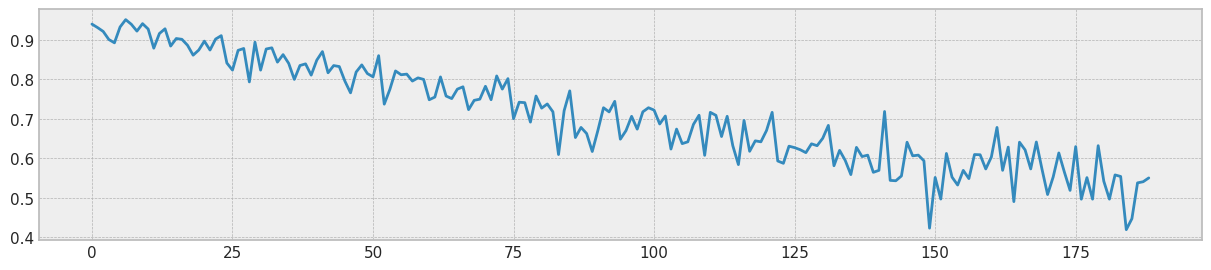

Mean F1 for all data: 0.7093912327161971
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 2.308876] [G loss: 0.692452]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 0.029047] [G loss: 0.678218]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 0.002014] [G loss: 0.650485]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: 0.001275] [G loss: 0.618969]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: 0.001573] [G loss: 0.576506]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: 0.002246] [G loss: 0.528631]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 0.002986] [G loss: 0.482340]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: 0.003619] [G loss: 0.442595]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: 0.004149] [G loss: 0.410263]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: 0.004788] [G loss: 0.383049]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: 0.005564] [G loss: 0.358547]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: 0.006608] [G loss: 0.334838]
[Lambda: 0.600000] [Epoch 2400/4000] [mi loss: 0.00772

100%|██████████| 189/189 [00:00<00:00, 371.00it/s]


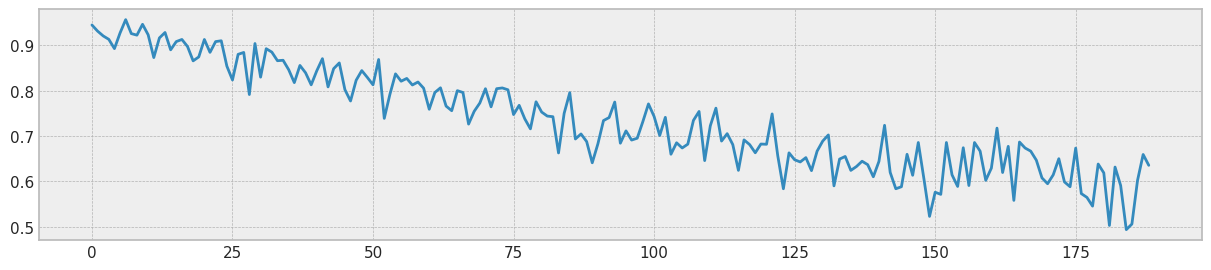

Mean F1 for all data: 0.7355301655618681
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 2.308876] [G loss: 0.692452]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 0.029325] [G loss: 0.678286]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 0.002039] [G loss: 0.650755]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: 0.001028] [G loss: 0.619590]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: 0.000947] [G loss: 0.577911]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 0.001157] [G loss: 0.531001]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 0.001445] [G loss: 0.485614]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 0.001703] [G loss: 0.446482]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: 0.001928] [G loss: 0.414634]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 0.002158] [G loss: 0.388241]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 0.002461] [G loss: 0.364729]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 0.002868] [G loss: 0.342346]
[Lambda: 0.700000] [Epoch 2400/4000] [mi loss: 0.00332

100%|██████████| 189/189 [00:00<00:00, 376.07it/s]


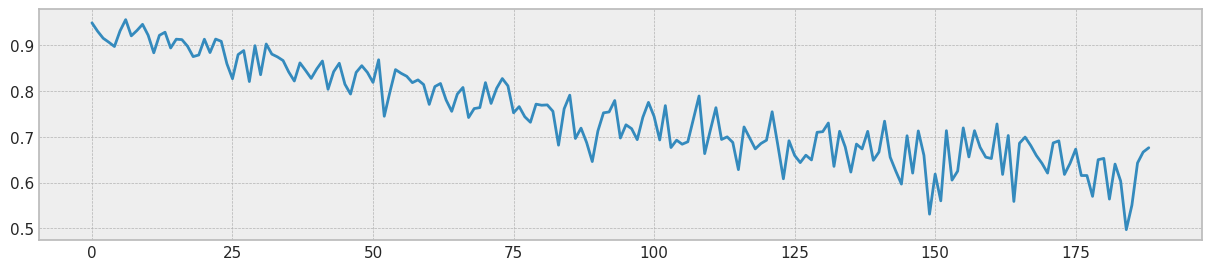

Mean F1 for all data: 0.7498405767810633
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 2.308876] [G loss: 0.692452]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 0.029547] [G loss: 0.678339]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 0.002039] [G loss: 0.650972]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: 0.000879] [G loss: 0.620109]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: 0.000642] [G loss: 0.579020]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: 0.000615] [G loss: 0.532895]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 0.000666] [G loss: 0.488249]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: 0.000728] [G loss: 0.449655]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: 0.000789] [G loss: 0.418245]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: 0.000853] [G loss: 0.392382]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: 0.000934] [G loss: 0.369586]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: 0.001056] [G loss: 0.348140]
[Lambda: 0.800000] [Epoch 2400/4000] [mi loss: 0.00118

100%|██████████| 189/189 [00:00<00:00, 370.77it/s]


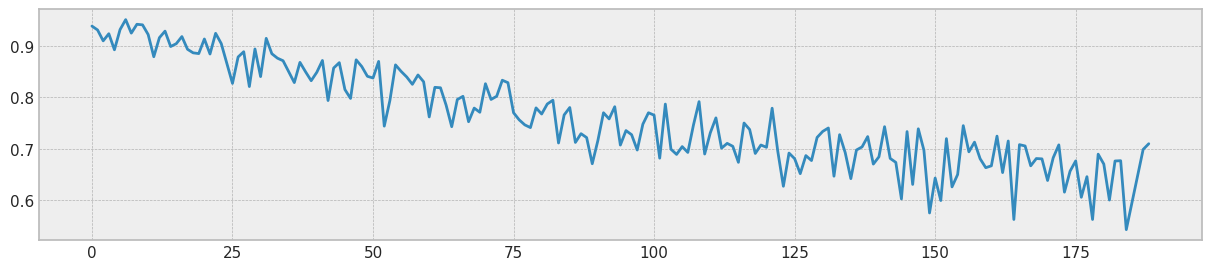

Mean F1 for all data: 0.7612282453665316
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 2.308876] [G loss: 0.692452]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 0.029730] [G loss: 0.678382]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 0.002066] [G loss: 0.651119]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: 0.000832] [G loss: 0.620498]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: 0.000505] [G loss: 0.579929]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: 0.000372] [G loss: 0.534471]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: 0.000316] [G loss: 0.490467]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 0.000286] [G loss: 0.452362]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: 0.000269] [G loss: 0.421374]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: 0.000259] [G loss: 0.395958]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: 0.000259] [G loss: 0.373664]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: 0.000270] [G loss: 0.352911]
[Lambda: 0.900000] [Epoch 2400/4000] [mi loss: 0.00028

100%|██████████| 189/189 [00:00<00:00, 357.92it/s]


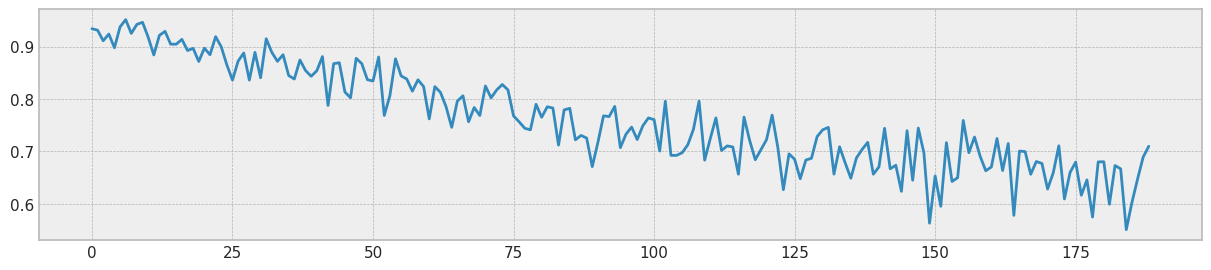

Mean F1 for all data: 0.7624466484164255


lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.000000
1  Case #2 Feature 5  0.881356  0.987952  0.877103  0.752137  0.000000
2  Case #3 Feature 5  0.961373  0.939394  0.731917  0.648148  0.005727
3  Case #3 Feature 4  0.961373  0.864583  0.857218  0.871560  0.005727
0                0.0  0.951220  0.944724  0.728273  0.663317  0.106044
1                0.1  0.932515  0.948980  0.523059  0.203125  0.118288
2                0.2  0.958084  0.939394  0.658272  0.470588  0.100244
3                0.3  0.941176  0.939394  0.661294  0.427673  0.099363
4                0.4  0.929412  0.940000  0.692210  0.481928  0.087953
5                0.5  0.917647  0.940000  0.709391  0.550562  0.092882
6                0.6  0.916667  0.944724  0.735530  0.635417  0.085659
7                0.7  0.911243  0.949495  0.749841  0.676190  0.097894
8                0.8  0.917647  0.938776  0.761228  0.709677  0.093258
9                0.9  0.917647  0.934010  0.762447  0.709677  0.093258

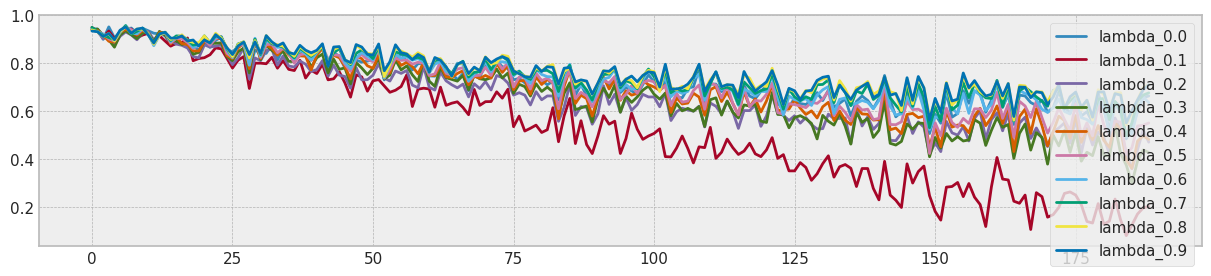

In [57]:
seed_everything()

train_result = []

avaible_range = 40000 

train_tensors = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#lambda_f_set = [0.4,0.5]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.



#lambda_f_set2 = [0.0000089,0.0000090,0.0000091] 
lambda_f_set2 = [1.0] 
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    #lambda_a2 = lambda_f2

    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter = train_model(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= lambda_f2 )# 0.00057)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator,last_adapter,X2[2000:][['x0','x1','x2','x3','z0','b']],y2[2000:])

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3))
    #plt.show()
    result4_df = pd.DataFrame(result_table2)

    #print(lambda_f2,result4_df)

pd.concat([pd.DataFrame(result_table3),result4_df])

## I(y^,z)을 최소화 하도록 학습
+ MINE을 적용, I(y^,z) 을 최소화 한다.

In [58]:
H=20
minibatch = 1000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2  

In [59]:

def test_model2(generator_, tX, ty, s1):
    generator_.eval()


    y_hat = generator_(tX)
    y_hat = (y_hat.data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)
    
    f1 = f1_score(ty,y_hat)
    #print('R-squared score',r2)
    mi_scores = make_mi_scores(pd.DataFrame(tX[:,4],columns=['z0']), y_hat, discrete_features="auto")
    mi = mi_scores['z0']
    print("Test f1 score: {}".format(f1))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))
#     min_eo = min(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     max_eo = max(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     print("Equal Opportunity ratio = {:.3f}".format(min_eo/max_eo))
    return f1, mi

In [60]:

def test_all_data2(generator,XT,yT):

    #XT = X[train_size:][['x0','x1','x2','x3','z0','b']]
    #yT = y[train_size:]
    print('XT.shape',XT.shape)
    bucket_size_array=[200]
    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)-1
        f1s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)
            #xs = adapter1(tmp_x[:,0:5],tmp_x[:,5].reshape(-1,1)/avaible_range)
            predicted_y = generator(tmp_x[:,0:5])
            predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
            f1 = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)
        plt.figure(figsize=(15,3))
        plt.plot(f1s)
        plt.show()

    print('Mean F1 for all data:',np.mean(f1s))   
    return f1s

In [61]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model2(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):

    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net()
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.01)
    minibatch = 1000

    for epoch in range(n_epochs):



        # -------------------
        #  Forwards Generator
        # -------------------
        gen_y = generator(XS_train[:,0:5]).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        # -------------------------------
        #  MINE
        # -------------------------------
        s = np.random.choice(XS_train.shape[0],minibatch)
        x_sample = Variable(torch.from_numpy(s1_train[s].data.numpy().reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        y_sample = gen_y[s] #Variable(torch.from_numpy(y1).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = gen_y[np.random.permutation(s)] # # #Variable(torch.from_numpy(np.random.permutation(y1)).type(torch.FloatTensor), requires_grad = True)    

        y2_sample = y_train[s].reshape(-1,1) #Variable(torch.from_numpy(y2).type(torch.FloatTensor), requires_grad = True)
        y2_shuffle = y_train[np.random.permutation(s)].reshape(-1,1) #Variable(torch.from_numpy(np.random.permutation(y2)).type(torch.FloatTensor), requires_grad = True)    

        ret1 = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
        ret2 = torch.mean(mine(x_sample, y2_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y2_shuffle))))

        # ret2(y의 샘플)는 maximize 하야 하고
        # ret1(y^의 샘플)는 0으로 minimize 해야 한다.!!! 
        mi_loss = - ret2 + torch.abs(ret1)

        mi_losses.append(-ret1)

        optimizer_G.zero_grad()
        optimizer_M.zero_grad()

        loss = (1-lambda_f) * g_loss +  lambda_f * mi_loss * alpha #* 0.05

        loss.backward()
        optimizer_G.step()
        optimizer_M.step()

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model2(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1,mi,generator

[Lambda: 0.000000] [Epoch 0/4000] [mi loss: 0.004281] [G loss: 0.688286]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss: 0.004374] [G loss: 0.674192]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss: 0.004780] [G loss: 0.654123]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss: 0.004425] [G loss: 0.626476]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss: 0.004409] [G loss: 0.587761]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss: 0.004902] [G loss: 0.542439]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss: 0.005716] [G loss: 0.497900]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss: 0.005826] [G loss: 0.459789]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss: 0.006631] [G loss: 0.428765]
[Lambda: 0.000000] [Epoch 1800/4000] [mi loss: 0.006763] [G loss: 0.403309]
[Lambda: 0.000000] [Epoch 2000/4000] [mi loss: 0.005473] [G loss: 0.381187]
[Lambda: 0.000000] [Epoch 2200/4000] [mi loss: 0.005503] [G loss: 0.360234]
[Lambda: 0.000000] [Epoch 2400/4000] [mi loss: 0.003759] [G loss: 0.339913]
[Lambda: 0.000000] 

100%|██████████| 189/189 [00:00<00:00, 485.26it/s]


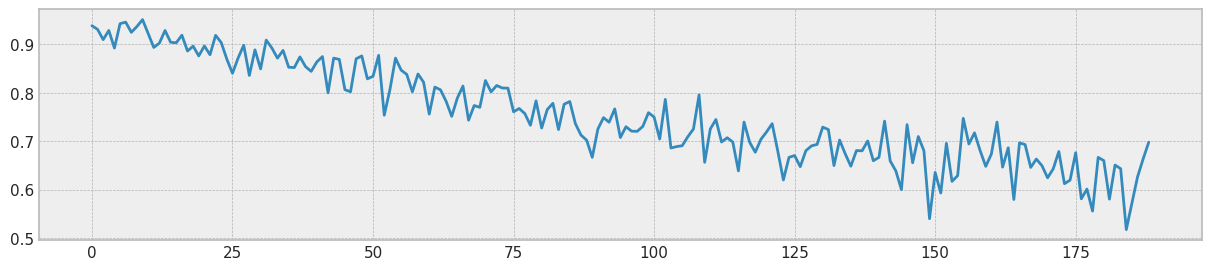

Mean F1 for all data: 0.7549047713504943
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 0.004483] [G loss: 0.688286]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 0.002499] [G loss: 0.674182]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 0.001154] [G loss: 0.654089]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: 0.001832] [G loss: 0.626541]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: 0.001426] [G loss: 0.587981]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: 0.003524] [G loss: 0.542716]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 0.000351] [G loss: 0.498162]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: 0.004398] [G loss: 0.460027]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: 0.003602] [G loss: 0.428976]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: 0.002789] [G loss: 0.403481]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: 0.000436] [G loss: 0.381309]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: 0.008289] [G loss: 0.360308]
[Lambda: 0.100000] [Epoch 2400/4000] [mi loss: 0.00382

100%|██████████| 189/189 [00:00<00:00, 476.98it/s]


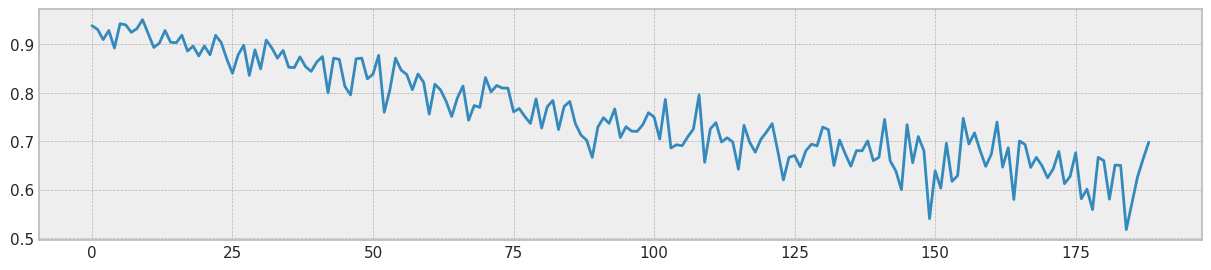

Mean F1 for all data: 0.755274498514965
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 0.004752] [G loss: 0.688286]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 0.001755] [G loss: 0.674179]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 0.001439] [G loss: 0.654054]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 0.000026] [G loss: 0.626593]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: 0.000041] [G loss: 0.588132]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 0.000838] [G loss: 0.542851]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: -0.003193] [G loss: 0.498284]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: 0.002720] [G loss: 0.460178]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: 0.007005] [G loss: 0.429120]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: -0.002375] [G loss: 0.403704]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: 0.000570] [G loss: 0.381616]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: 0.000642] [G loss: 0.360772]
[Lambda: 0.200000] [Epoch 2400/4000] [mi loss: -0.010

100%|██████████| 189/189 [00:00<00:00, 502.54it/s]


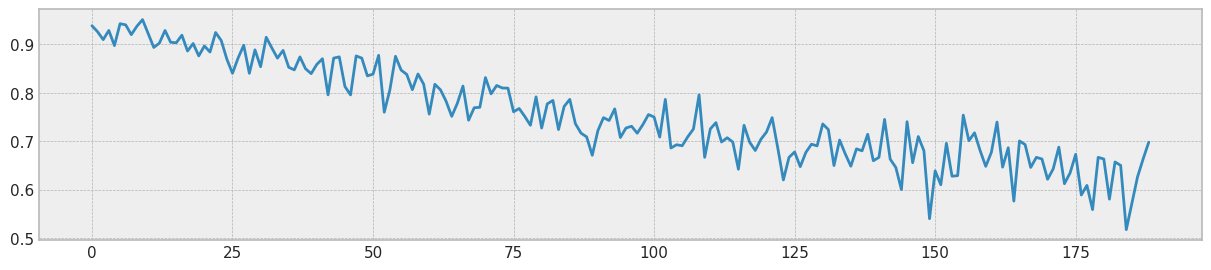

Mean F1 for all data: 0.7562572739244128
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 0.004541] [G loss: 0.688286]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 0.002210] [G loss: 0.674221]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 0.001367] [G loss: 0.654039]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 0.001246] [G loss: 0.626574]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: 0.002213] [G loss: 0.587917]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: -0.002035] [G loss: 0.542455]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: -0.001071] [G loss: 0.497823]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: 0.000783] [G loss: 0.459799]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: 0.009970] [G loss: 0.429000]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: 0.000830] [G loss: 0.403749]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: 0.003123] [G loss: 0.381755]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: -0.003362] [G loss: 0.361069]
[Lambda: 0.300000] [Epoch 2400/4000] [mi loss: 0.00

100%|██████████| 189/189 [00:00<00:00, 495.84it/s]


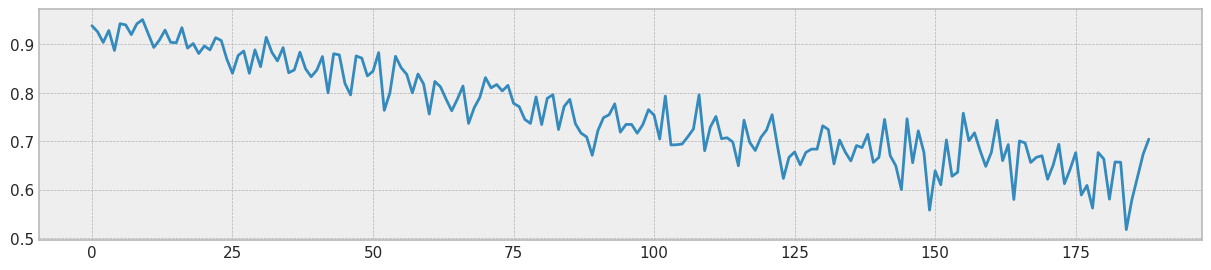

Mean F1 for all data: 0.758698524526999
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 0.004761] [G loss: 0.688286]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 0.003789] [G loss: 0.674318]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 0.002115] [G loss: 0.654124]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 0.001449] [G loss: 0.626603]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 0.001671] [G loss: 0.587424]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 0.004951] [G loss: 0.541553]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 0.001085] [G loss: 0.496875]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 0.000167] [G loss: 0.459033]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 0.000696] [G loss: 0.428479]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 0.005329] [G loss: 0.403568]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: -0.002497] [G loss: 0.381755]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 0.004906] [G loss: 0.361433]
[Lambda: 0.400000] [Epoch 2400/4000] [mi loss: 0.00261

100%|██████████| 189/189 [00:00<00:00, 515.69it/s]


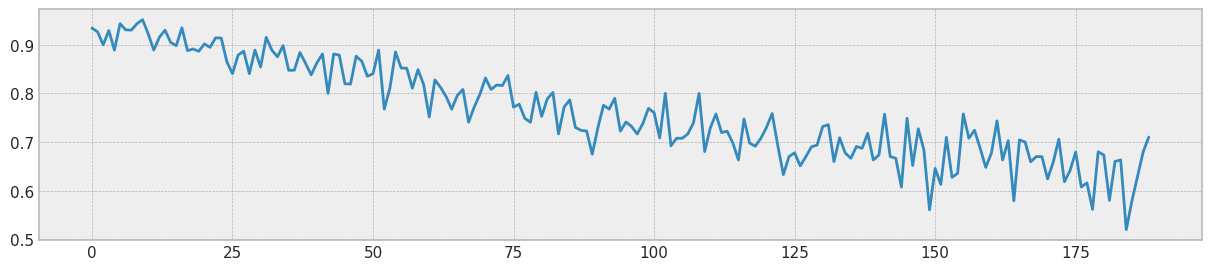

Mean F1 for all data: 0.7627093845870628
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 0.004461] [G loss: 0.688286]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 0.001394] [G loss: 0.674479]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 0.001499] [G loss: 0.654294]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: -0.000312] [G loss: 0.626417]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 0.001090] [G loss: 0.586615]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 0.000113] [G loss: 0.540352]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: -0.001488] [G loss: 0.495959]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 0.000845] [G loss: 0.458454]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: -0.001029] [G loss: 0.428221]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: -0.000648] [G loss: 0.403445]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: -0.002875] [G loss: 0.381946]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: -0.007502] [G loss: 0.362159]
[Lambda: 0.500000] [Epoch 2400/4000] [mi loss: 0

100%|██████████| 189/189 [00:00<00:00, 500.47it/s]


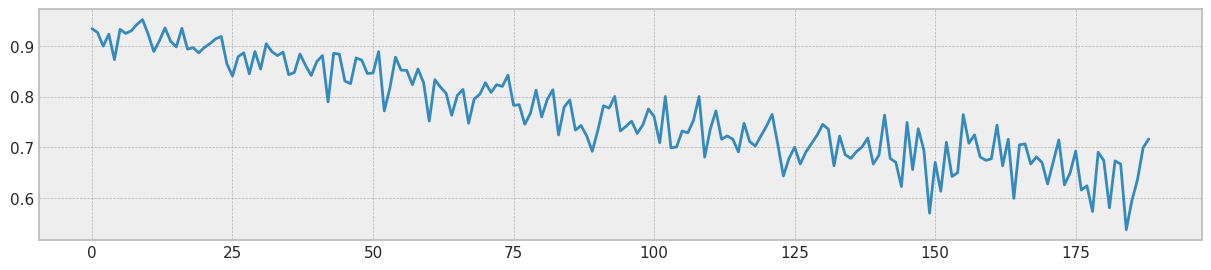

Mean F1 for all data: 0.7684933704330398
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 0.004821] [G loss: 0.688286]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 0.001985] [G loss: 0.674669]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 0.001202] [G loss: 0.654215]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: 0.001459] [G loss: 0.625850]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: -0.000750] [G loss: 0.586505]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: -0.001293] [G loss: 0.540944]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 0.002656] [G loss: 0.497089]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: -0.004899] [G loss: 0.459610]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: 0.000762] [G loss: 0.429087]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: -0.003359] [G loss: 0.404423]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: -0.000500] [G loss: 0.382962]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: -0.001468] [G loss: 0.363623]
[Lambda: 0.600000] [Epoch 2400/4000] [mi loss: 0

100%|██████████| 189/189 [00:00<00:00, 512.75it/s]


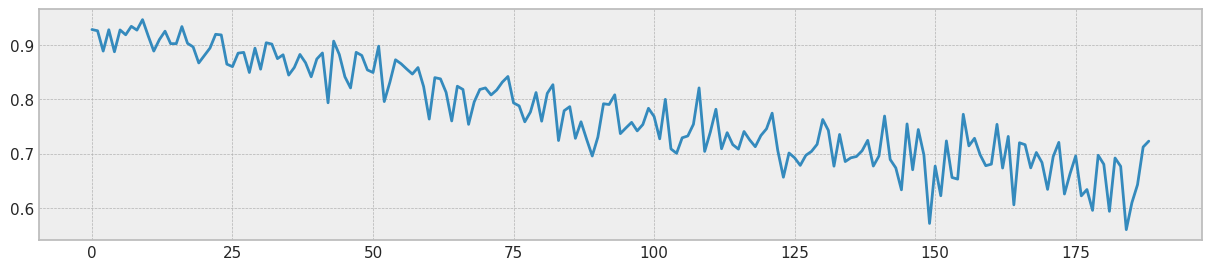

Mean F1 for all data: 0.7747406353371912
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 0.004345] [G loss: 0.688286]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 0.001117] [G loss: 0.675422]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 0.002069] [G loss: 0.654484]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: 0.001132] [G loss: 0.626734]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: -0.001410] [G loss: 0.589757]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: -0.003762] [G loss: 0.546047]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: -0.000117] [G loss: 0.502914]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 0.004363] [G loss: 0.465319]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: -0.000587] [G loss: 0.434518]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 0.003155] [G loss: 0.409169]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 0.004851] [G loss: 0.387322]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 0.004879] [G loss: 0.368313]
[Lambda: 0.700000] [Epoch 2400/4000] [mi loss: 0.0

100%|██████████| 189/189 [00:00<00:00, 515.18it/s]


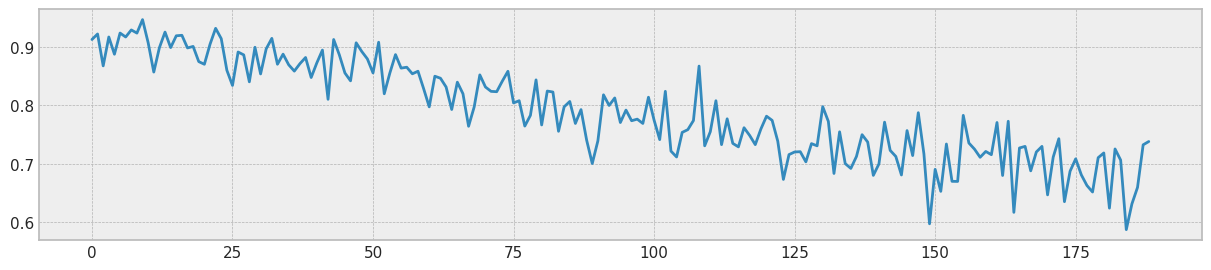

Mean F1 for all data: 0.78975395051077
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 0.004587] [G loss: 0.688286]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 0.002495] [G loss: 0.678276]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 0.001193] [G loss: 0.659510]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: -0.001049] [G loss: 0.633211]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: 0.000577] [G loss: 0.600634]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: 0.000379] [G loss: 0.561401]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 0.002330] [G loss: 0.521577]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: 0.002079] [G loss: 0.484636]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: -0.005340] [G loss: 0.452552]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: -0.001824] [G loss: 0.426023]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: -0.006878] [G loss: 0.403542]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: 0.001738] [G loss: 0.383793]
[Lambda: 0.800000] [Epoch 2400/4000] [mi loss: -0.00

100%|██████████| 189/189 [00:00<00:00, 487.52it/s]


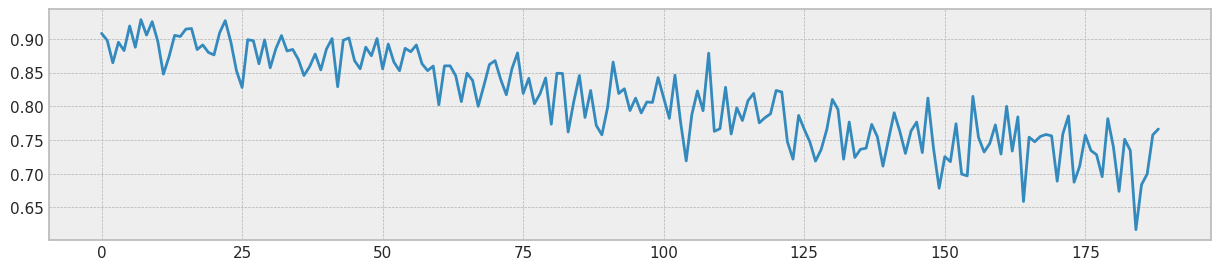

Mean F1 for all data: 0.810463709448865
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 0.004719] [G loss: 0.688286]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 0.000288] [G loss: 0.684078]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 0.000095] [G loss: 0.677167]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: 0.000727] [G loss: 0.666339]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: 0.000828] [G loss: 0.651068]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: -0.001243] [G loss: 0.630731]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: -0.001333] [G loss: 0.604844]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 0.001559] [G loss: 0.573003]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: 0.000219] [G loss: 0.538776]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: -0.005018] [G loss: 0.506329]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: 0.000915] [G loss: 0.478867]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: 0.001105] [G loss: 0.455221]
[Lambda: 0.900000] [Epoch 2400/4000] [mi loss: -0.00

100%|██████████| 189/189 [00:00<00:00, 487.58it/s]


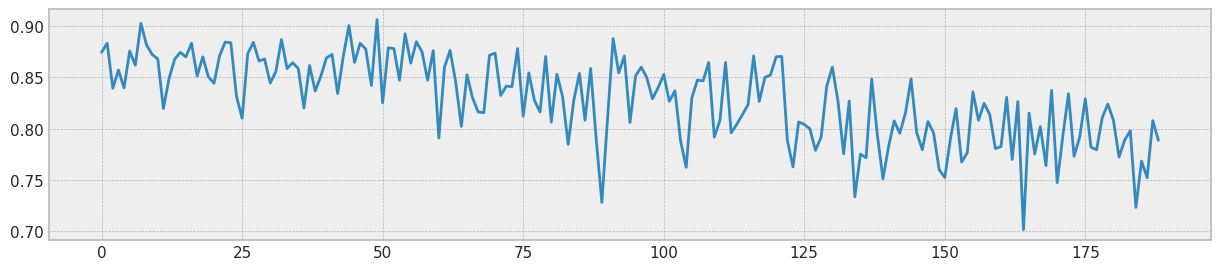

Mean F1 for all data: 0.8292081494615547


lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.000000
1  Case #2 Feature 5  0.881356  0.987952  0.877103  0.752137  0.000000
2  Case #3 Feature 5  0.961373  0.939394  0.731917  0.648148  0.005727
3  Case #3 Feature 4  0.961373  0.864583  0.857218  0.871560  0.005727
0                0.0  0.917647  0.938776  0.754905  0.698113  0.093258
1                0.1  0.917647  0.938776  0.755274  0.698113  0.093258
2                0.2  0.918605  0.938776  0.756257  0.698113  0.076941
3                0.3  0.918605  0.938776  0.758699  0.704225  0.076941
4                0.4  0.918605  0.934010  0.762709  0.710280  0.076941
5                0.5  0.918605  0.934010  0.768493  0.716279  0.076941
6                0.6  0.916667  0.928571  0.774741  0.723005  0.047747
7                0.7  0.903614  0.912821  0.789754  0.738318  0.008811
8                0.8  0.891566  0.908163  0.810464  0.766355  0.000000
9                0.9  0.825581  0.874372  0.829208  0.788732  0.000000

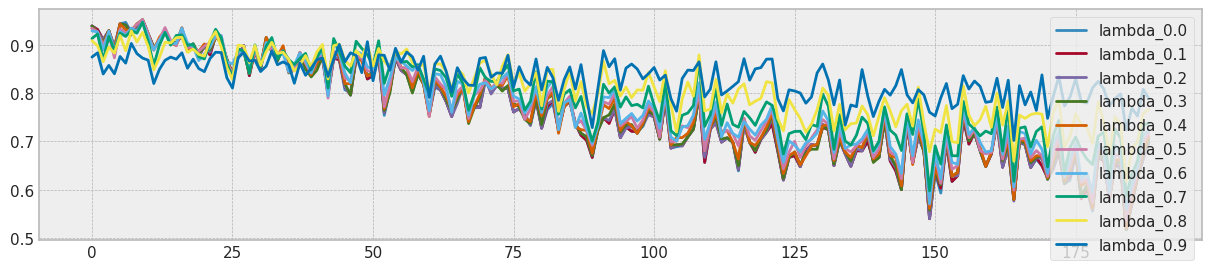

In [62]:
seed_everything()

train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.5] #[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
#lambda_f_set = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30] # Lambda value for the fairness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:

    f1,mi,last_generator = train_model2(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed,alpha=1.0)
    result_table[f'lambda_{lambda_f}'] = test_all_data2(last_generator,X2[2000:][['x0','x1','x2','x3','z0','b']], y2[2000:])

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))
#plt.show()
result4_df = pd.DataFrame(result_table2)

#print(lambda_f2,result4_df)


pd.concat([pd.DataFrame(result_table3),result4_df])

## b를 대입하여 b가 작을때는 I(y^,z)을 최대화, b가 커질수록I(y^,z)을 최소화 하도록 학습
+ MINE을 적용, I(G(x,b=0),z) 을 최대화, I(G(x,b=1),z) 을 최소화 한다.

In [63]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model3(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):

    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    a_losses =[]
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net()
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)

    minibatch = 1000

    for epoch in range(n_epochs):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------
        xs = adapter(XS_train[:,0:5],XS_train[:,5].reshape(-1,1)/avaible_range) # z0, b
        a_loss = torch.sum(mse_loss(xs, XS_train[:,0:5]))
        a_losses.append(a_loss)
        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        #  Forwards Generator b=1
        gen_y0 = generator(adapter(XS_train[:,0:5],torch.zeros(XS_train.shape[0],1))).reshape(-1,1)
        gen_y1 = generator(adapter(XS_train[:,0:5], torch.ones(XS_train.shape[0],1)*0.3)).reshape(-1,1)

        # -------------------------------
        #  MINE
        # -------------------------------
        s = np.random.choice(XS_train.shape[0],minibatch)
        x_sample = Variable(torch.from_numpy(s1_train[s].data.numpy().reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        y_sample = gen_y0[s] #Variable(torch.from_numpy(y1).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = gen_y0[np.random.permutation(s)] # # #Variable(torch.from_numpy(np.random.permutation(y1)).type(torch.FloatTensor), requires_grad = True)    

        y2_sample = gen_y1[s]
        y2_shuffle = gen_y1[np.random.permutation(s)] #Variable(torch.from_numpy(np.random.permutation(y2)).type(torch.FloatTensor), requires_grad = True)    

        ret1 = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
        ret2 = torch.mean(mine(x_sample, y2_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y2_shuffle))))

        # ret1(y^(b=0)의 샘플)는 maximize 하야 하고
        # ret2(y^(b=1)의 샘플)는 0으로 minimize 해야 한다.!!! 
        mi_loss = - ret1 + torch.abs(ret2)

        mi_losses.append(-ret2)


        optimizer_A.zero_grad()
        optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        loss = (1-lambda_f) * (g_loss +  a_loss) + lambda_f * mi_loss

        loss.backward()
        optimizer_G.step()
        optimizer_M.step()
        optimizer_A.step()            

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss: %f] [A loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses[-1], a_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator,adapter, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1,mi,generator,adapter

[Lambda: 0.000000] [Epoch 0/4000] [mi loss: 0.004056] [A loss: 2.308876] [G loss: 0.692452]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss: 0.004342] [A loss: 0.028679] [G loss: 0.678121]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss: 0.004594] [A loss: 0.002055] [G loss: 0.650132]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss: 0.004536] [A loss: 0.001813] [G loss: 0.618110]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss: 0.004798] [A loss: 0.002850] [G loss: 0.574580]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss: 0.004574] [A loss: 0.004402] [G loss: 0.525508]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss: 0.005732] [A loss: 0.005972] [G loss: 0.478184]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss: 0.005776] [A loss: 0.007322] [G loss: 0.437702]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss: 0.005019] [A loss: 0.008580] [G loss: 0.404519]
[Lambda: 0.000000] [Epoch 1800/4000] [mi loss: 0.005095] [A loss: 0.009990] [G loss: 0.376273]
[Lambda: 0.000000] [Epoch 2000/4000] [mi loss: 0.004306] 

100%|██████████| 189/189 [00:00<00:00, 375.68it/s]


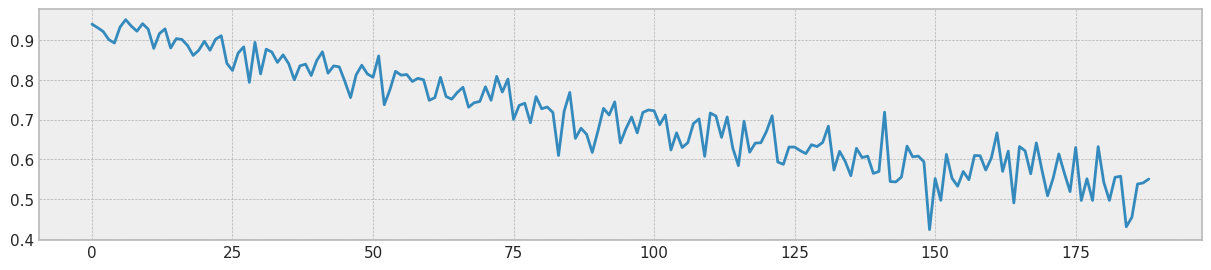

Mean F1 for all data: 0.7085355408658138
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 0.004248] [A loss: 2.308876] [G loss: 0.692452]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 0.000037] [A loss: 0.028685] [G loss: 0.678124]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: -0.000068] [A loss: 0.002055] [G loss: 0.650131]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: -0.000076] [A loss: 0.001813] [G loss: 0.618110]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: -0.000054] [A loss: 0.002849] [G loss: 0.574580]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: -0.000106] [A loss: 0.004401] [G loss: 0.525504]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 0.000017] [A loss: 0.005973] [G loss: 0.478175]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: -0.000215] [A loss: 0.007323] [G loss: 0.437694]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: -0.000191] [A loss: 0.008583] [G loss: 0.404502]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: -0.000125] [A loss: 0.010012] [G loss: 0.376222]
[Lambda: 

100%|██████████| 189/189 [00:00<00:00, 371.54it/s]


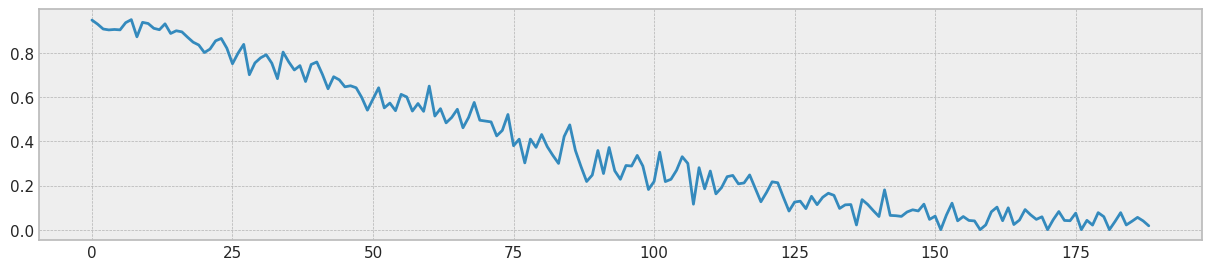

Mean F1 for all data: 0.3791789841940623
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 0.004458] [A loss: 2.308876] [G loss: 0.692452]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 0.000042] [A loss: 0.028690] [G loss: 0.678137]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: -0.000019] [A loss: 0.002055] [G loss: 0.650137]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 0.000001] [A loss: 0.001814] [G loss: 0.618085]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: -0.000094] [A loss: 0.002850] [G loss: 0.574529]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 0.000026] [A loss: 0.004403] [G loss: 0.525444]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: -0.000124] [A loss: 0.005972] [G loss: 0.478124]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: -0.000044] [A loss: 0.007327] [G loss: 0.437644]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: -0.000146] [A loss: 0.008585] [G loss: 0.404458]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: -0.000098] [A loss: 0.010019] [G loss: 0.376171]
[Lambda: 0

100%|██████████| 189/189 [00:00<00:00, 381.59it/s]


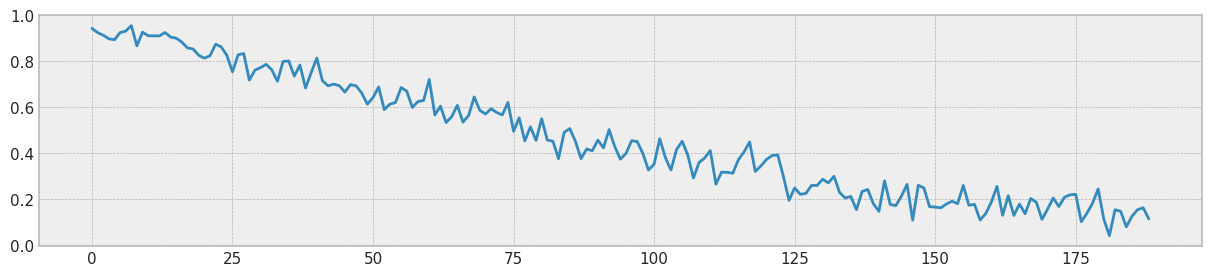

Mean F1 for all data: 0.4668059283368429
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 0.004271] [A loss: 2.308876] [G loss: 0.692452]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 0.000015] [A loss: 0.028701] [G loss: 0.678150]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: -0.000036] [A loss: 0.002055] [G loss: 0.650144]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 0.000025] [A loss: 0.001814] [G loss: 0.618078]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: 0.000083] [A loss: 0.002849] [G loss: 0.574515]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: 0.000006] [A loss: 0.004400] [G loss: 0.525431]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: -0.000058] [A loss: 0.005972] [G loss: 0.478110]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: -0.000071] [A loss: 0.007328] [G loss: 0.437621]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: -0.000197] [A loss: 0.008578] [G loss: 0.404448]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: -0.000253] [A loss: 0.010016] [G loss: 0.376157]
[Lambda: 0.

100%|██████████| 189/189 [00:00<00:00, 373.85it/s]


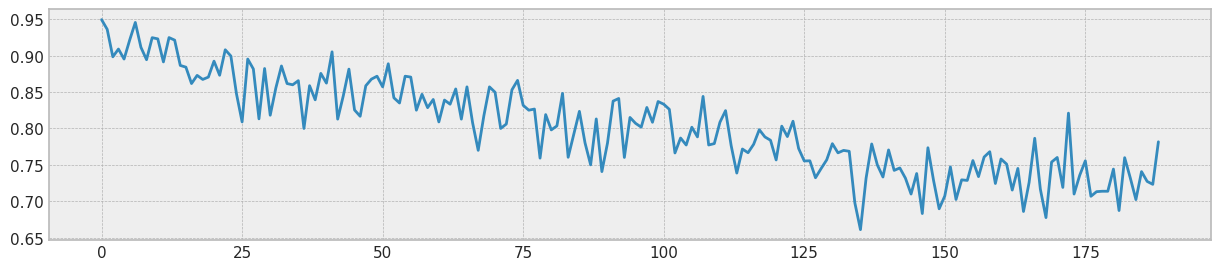

Mean F1 for all data: 0.8029226953990477
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 0.004475] [A loss: 2.308876] [G loss: 0.692452]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 0.000037] [A loss: 0.028711] [G loss: 0.678160]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: -0.000052] [A loss: 0.002055] [G loss: 0.650147]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: -0.000086] [A loss: 0.001814] [G loss: 0.618050]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 0.000018] [A loss: 0.002850] [G loss: 0.574452]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: -0.000100] [A loss: 0.004395] [G loss: 0.525367]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: -0.000174] [A loss: 0.005966] [G loss: 0.478052]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: -0.000288] [A loss: 0.007330] [G loss: 0.437565]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: -0.000033] [A loss: 0.008591] [G loss: 0.404372]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: -0.000541] [A loss: 0.010035] [G loss: 0.376053]
[Lambda: 

100%|██████████| 189/189 [00:00<00:00, 388.93it/s]


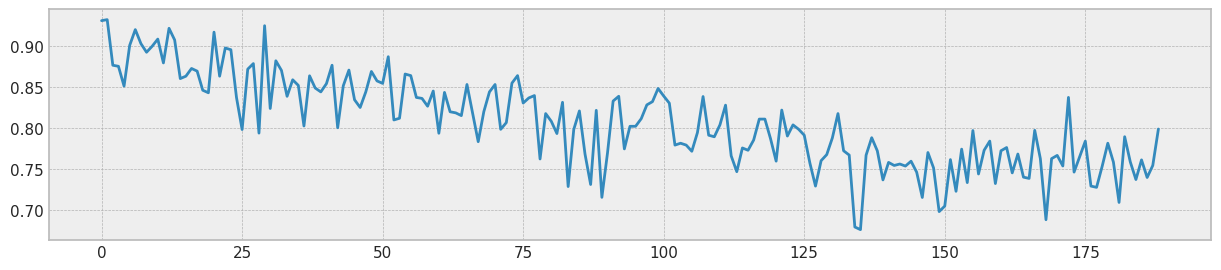

Mean F1 for all data: 0.8064718621707628
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 0.004230] [A loss: 2.308876] [G loss: 0.692452]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 0.000048] [A loss: 0.028724] [G loss: 0.678185]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: -0.000001] [A loss: 0.002055] [G loss: 0.650162]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: -0.000027] [A loss: 0.001815] [G loss: 0.618015]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: -0.000121] [A loss: 0.002852] [G loss: 0.574383]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: -0.000067] [A loss: 0.004399] [G loss: 0.525283]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: -0.000333] [A loss: 0.005978] [G loss: 0.477971]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: -0.000190] [A loss: 0.007340] [G loss: 0.437498]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: -0.000359] [A loss: 0.008581] [G loss: 0.404345]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: -0.000844] [A loss: 0.010156] [G loss: 0.375838]
[Lambda:

100%|██████████| 189/189 [00:00<00:00, 365.36it/s]


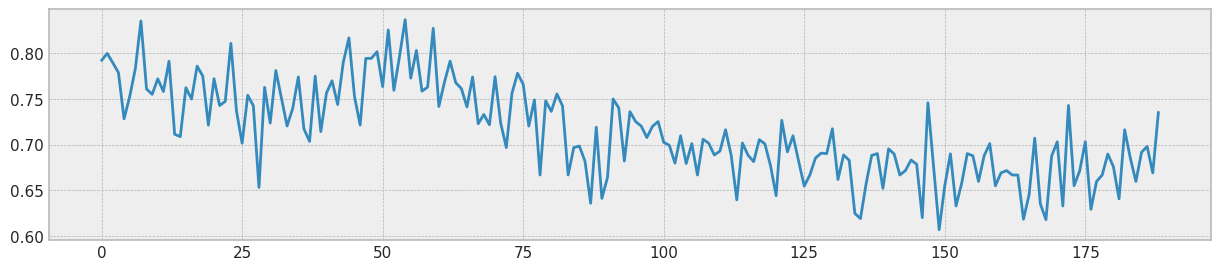

Mean F1 for all data: 0.7150427592909063
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 0.004572] [A loss: 2.308876] [G loss: 0.692452]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 0.000012] [A loss: 0.028757] [G loss: 0.678230]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: -0.000047] [A loss: 0.002053] [G loss: 0.650167]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: -0.000052] [A loss: 0.001816] [G loss: 0.617914]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: -0.000038] [A loss: 0.002855] [G loss: 0.574200]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: -0.000213] [A loss: 0.004396] [G loss: 0.525085]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 0.000011] [A loss: 0.005965] [G loss: 0.477816]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: -0.000222] [A loss: 0.007323] [G loss: 0.437375]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: -0.000070] [A loss: 0.008601] [G loss: 0.404178]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: -0.000491] [A loss: 0.010068] [G loss: 0.375815]
[Lambda: 

100%|██████████| 189/189 [00:00<00:00, 343.28it/s]


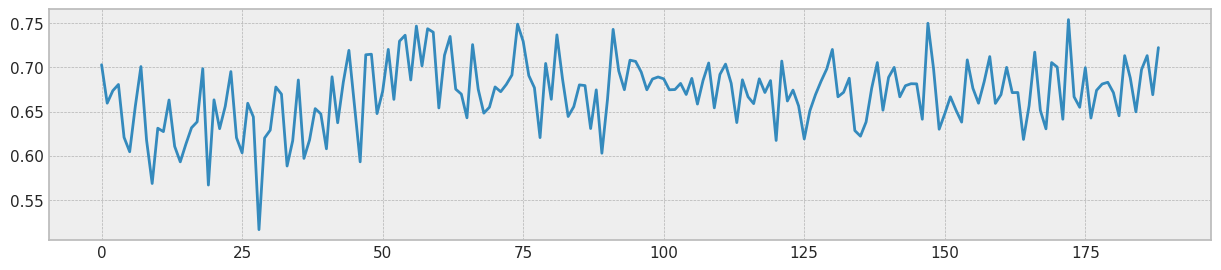

Mean F1 for all data: 0.6696604814605029
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 0.004192] [A loss: 2.308876] [G loss: 0.692452]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 0.000073] [A loss: 0.028807] [G loss: 0.678306]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: -0.000068] [A loss: 0.002058] [G loss: 0.650214]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: -0.000036] [A loss: 0.001818] [G loss: 0.617796]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: 0.000016] [A loss: 0.002864] [G loss: 0.573911]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 0.000041] [A loss: 0.004405] [G loss: 0.524768]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: -0.000134] [A loss: 0.005971] [G loss: 0.477540]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 0.000167] [A loss: 0.007370] [G loss: 0.437041]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: -0.000138] [A loss: 0.008577] [G loss: 0.403943]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: -0.000214] [A loss: 0.010227] [G loss: 0.375318]
[Lambda: 0.

100%|██████████| 189/189 [00:00<00:00, 365.55it/s]


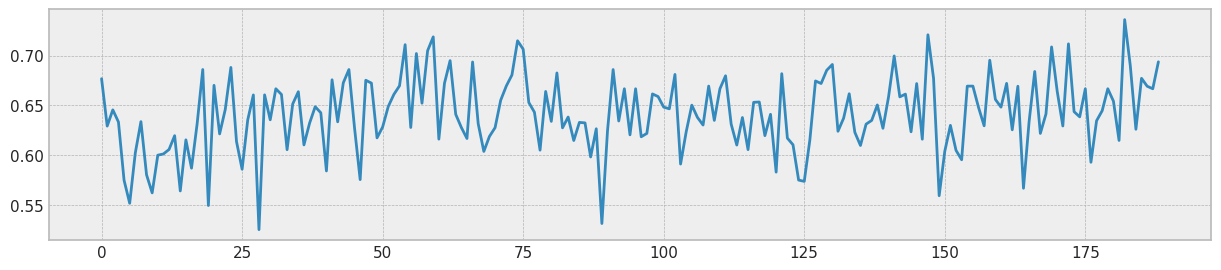

Mean F1 for all data: 0.6410610632508607
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 0.004272] [A loss: 2.308876] [G loss: 0.692452]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 0.000048] [A loss: 0.028876] [G loss: 0.678433]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: -0.000023] [A loss: 0.002055] [G loss: 0.650257]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: -0.000003] [A loss: 0.001821] [G loss: 0.617610]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: -0.000075] [A loss: 0.002872] [G loss: 0.573550]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: -0.000183] [A loss: 0.004398] [G loss: 0.524359]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: -0.000247] [A loss: 0.005964] [G loss: 0.477160]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: -0.000199] [A loss: 0.007377] [G loss: 0.436743]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: -0.000247] [A loss: 0.008602] [G loss: 0.403690]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: -0.000235] [A loss: 0.011001] [G loss: 0.374247]
[Lambda:

100%|██████████| 189/189 [00:00<00:00, 369.67it/s]


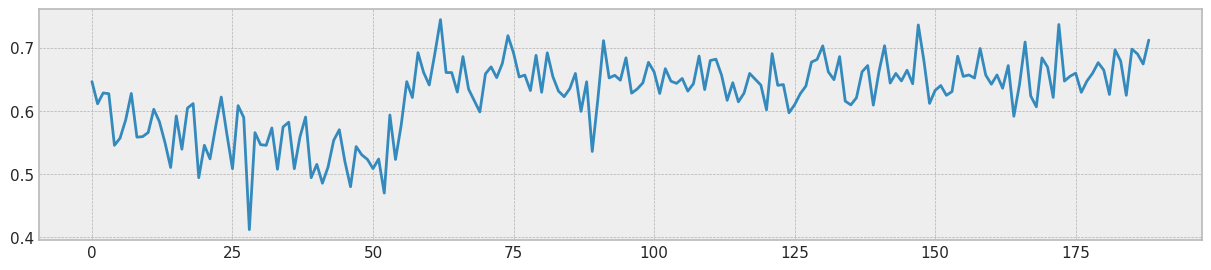

Mean F1 for all data: 0.6238561822517326
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 0.004436] [A loss: 2.308876] [G loss: 0.692452]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 0.000040] [A loss: 0.029141] [G loss: 0.679028]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: -0.000055] [A loss: 0.002060] [G loss: 0.650556]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: 0.000025] [A loss: 0.001858] [G loss: 0.616921]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: -0.000131] [A loss: 0.002954] [G loss: 0.572598]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: -0.000061] [A loss: 0.004456] [G loss: 0.523108]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: -0.000280] [A loss: 0.005961] [G loss: 0.476139]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 0.000052] [A loss: 0.007422] [G loss: 0.435694]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: -0.000475] [A loss: 0.009376] [G loss: 0.402037]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: -0.000320] [A loss: 0.016984] [G loss: 0.369044]
[Lambda: 0

100%|██████████| 189/189 [00:00<00:00, 370.67it/s]


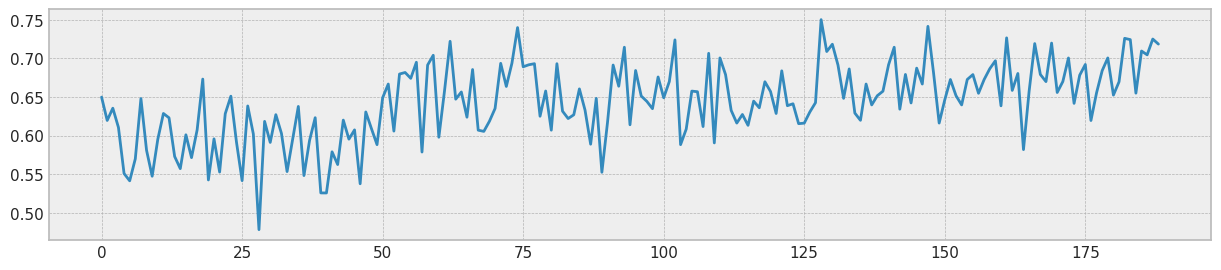

Mean F1 for all data: 0.6428365828348013


lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.000000
1  Case #2 Feature 5  0.881356  0.987952  0.877103  0.752137  0.000000
2  Case #3 Feature 5  0.961373  0.939394  0.731917  0.648148  0.005727
3  Case #3 Feature 4  0.961373  0.864583  0.857218  0.871560  0.005727
0                0.0  0.923077  0.940000  0.708536  0.550562  0.080749
1                0.1  0.923077  0.949495  0.379179  0.017391  0.080749
2                0.2  0.929412  0.944162  0.466806  0.115702  0.087953
3                0.3  0.923977  0.949495  0.802923  0.781690  0.110967
4                0.4  0.908046  0.930693  0.806472  0.798450  0.142336
5                0.5  0.791444  0.792271  0.715043  0.735484  0.334045
6                0.6  0.670213  0.702970  0.669660  0.722408  0.612967
7                0.7  0.652174  0.676768  0.641061  0.693727  0.642304
8                0.8  0.629834  0.646154  0.623856  0.711864  0.685822
9                0.9  0.629834  0.649746  0.642837  0.718367  0.685822

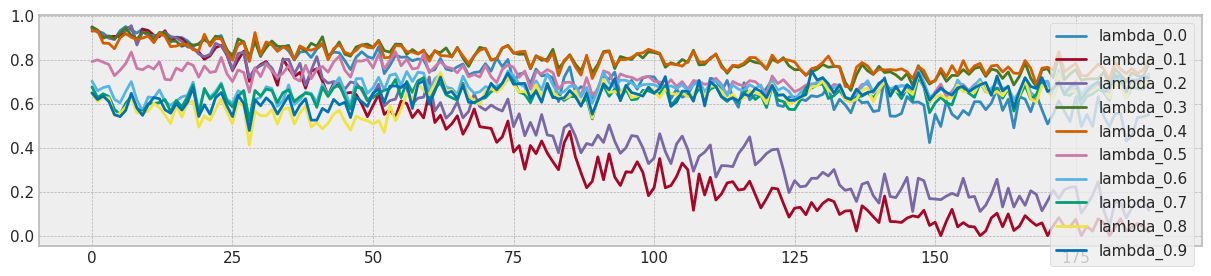

In [64]:
seed_everything()

train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.5] #[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
#lambda_f_set = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30] # Lambda value for the fairness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:

    f1,mi,last_generator, last_adapter = train_model3(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed,alpha=1.0)
    result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator,last_adapter, X2[2000:][['x0','x1','x2','x3','z0','b']], y2[2000:])

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))
#plt.show()
result4_df = pd.DataFrame(result_table2)

#print(lambda_f2,result4_df)


pd.concat([pd.DataFrame(result_table3),result4_df])